# Data science request #5 - an exploratory approach

* Authors: **David <david@omind.me>** & **Raph <raphaelle@omind.me>**
* Date: 2019-07-22
* Link to trello card: https://trello.com/c/AS5yTMSC

The original research question was:

> Estimation de la distribution dans la population des individus qui s'activent plutôt en tonique ou plutôt en phasique (profils de régulation physiologique - gestion du stress) + sélection de features et clustering

This notebook is a straight forward analysis to start working towards this question
with a simple linear regression and a clustering approach.
The main purpose is to keep this analysis simple and interpretable. 

-------------------------------------------------

# Summary


This analysis aims to study the different galvanic activation profiles during the virtual reality experiment. The analysis is in two stages:
 - it starts by training an activation model to estimate the probability of an observation to witness 'phasic activation' or 'tonic activation'. In order to train and cross-validated the model, we need to select sequences to be labeled as 'rest' versus 'stress'. **Those are to be discussed.** 
 - then, once we have quantified the SCL and SCR activations, for each observation (ie. one participant during one module), we:
     - visualize the relationships between these two activations (SCR and SCL) and their distributions against the context (ie. across modules or given the game difficulty). **The conclusion is that there is a correlation of 0.5 between phasic and tonic activations. In 75% of the observations, tonic activation (resp. decompression) goes together with phasic activation (resp. decompression); In 18.2 % of observations, we have tonic activation without phasic activation; In 7.4% of observations with have a phasic activation without tonic activation**
     - select a subset of VR stimulations (eg. attack waves and suveys during space-stress) and cluster participants given their activations during those given stimulations. 
     - estimate the variances and covariances between phasic/tonic activation and the context in space-stress (ie. shaped by wave difficulty and surveys)  
     - **We could not clearly identify clusters**. 

# Details

Note that for this notebook, I am trying to discuss the results *before* showing the related figure or table.

## Preparations

Code needed to import or prepare libraries needed for this notebook.

Common important libraries:

In [1]:
%matplotlib inline

import collections
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Set a random seed for reproducibility
np.random.seed(42)

Connection with **R** needed to use `ggplot` and import common important R libraries

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

library(ggplot2)
library(GGally)

Configuration of **Quetzal** client to obtain data

In [4]:
from quetzal.client import helpers

if 'QUETZAL_USER' not in os.environ or 'QUETZAL_PASSWORD' not in os.environ:
    raise ValueError('You need to set the quetzal environment variables '
                     'to retrieve the data of this notebook')

client = helpers.get_client(
    url='https://quetzal.omind.me/api/v1',
    username=os.getenv('QUETZAL_USER'),
    password=os.getenv('QUETZAL_PASSWORD'),
    insecure=False
)
helpers.auth.login(client);  # Just to check if the username/password works

## Data

This section consists on a description of how the GSR dataset is defined, then
how this dataset was converted to different shapes specific for this analysis.

### GSR dataset

Dataset for this notebook is the GSR feature matrix from Iguazu version 0.0.3.

The following cell downloads the GSR features locally:

In [5]:
GSR_SUMMARY_ID = '7e30a399-fc86-4796-bd85-de1e4045edcc'

gsr_csv = helpers.file.download(client, file_id=GSR_SUMMARY_ID, wid=50, output_dir='data')
print('GSR features CSV downloaded at', gsr_csv)

GSR features CSV downloaded at /Users/raph/PycharmProject/OpenMindInnovation/backpack/notebooks/gsr_sandbox/data/galvanic_summary.csv


... and now we can read it with pandas:

In [6]:
df = pd.read_csv(gsr_csv, index_col=0)  # index_col=0 needed because it was saved without xxx.to_csv(..., index=False)
print('Dataframe has shape', df.shape)
df.head()

Dataframe has shape (10425, 11)


sequence  \
0                   physio-sonification_playground_0   
1  common_respiration-calibration_data-accumulati...   
2                         cardiac-coherence_survey_0   
3                         cardiac-coherence_survey_1   
4                                   intro_sequence_0   

                                file_id         gsr_SCL_auc  \
0  c4bc0119-1a92-47ed-b8b8-3c2189834e75  -146.5431735952826   
1  c4bc0119-1a92-47ed-b8b8-3c2189834e75  15.709697303017279   
2  c4bc0119-1a92-47ed-b8b8-3c2189834e75  -2.233287200473388   
3  c4bc0119-1a92-47ed-b8b8-3c2189834e75  3.6625029876525463   
4  c4bc0119-1a92-47ed-b8b8-3c2189834e75  28.795595408886015   

  gsr_SCL_linregress_rvalue gsr_SCL_linregress_slope        gsr_SCL_median  \
0       -0.9679966623342071       -1549.590377574245   -1.2061493371312892   
1        0.9784691733695751       208.95032906323303   0.41808914688888077   
2        0.9646707358942439       361.67208590640246  -0.20966292507259246   
3        0.5628684798298581       277.43952888410024   0.12323154504876604   
4        0.9330577537586806        272.0991817971644   0.35111316106828316   

            gsr_SCL_ptp          gsr_SCL_std  gsr_SCR_peaks_detected_rate  \
0  -0.15693635174815698  0.01867699183135612                    -0.074933   
1    0.0493048821846129  0.09516126831345538                     0.012128   
2  -0.11687661482836628  0.03916363906518962                    -0.042746   
3   0.13866946555743895  0.10520032835068692                    -0.018432   
4    0.1918150726663144  0.15001518842185532                    -0.006586   

   gsr_SCR_peaks_increase-amplitude_median  \
0                                 0.000000   
1                                 0.199802   
2                                 0.064881   
3                                 0.244139   
4                                 0.130039   

   gsr_SCR_peaks_increase-duration_median  
0                                0.000000  
1                                3.439298  
2                                2.441296  
3                                2.265523  
4                                4.269339

In [7]:
duplicated_fid = np.unique(df[df.drop('file_id', axis=1).duplicated()].replace('bad', np.NaN).dropna().file_id)
print(f'Found {len(duplicated_fid)} duplicated files: {duplicated_fid}. Removing it from further analysis. ')
df = df[~df.file_id.isin(duplicated_fid)]

Found 1 duplicated files: ['72d0dda5-2697-430b-855f-8f8023084185']. Removing it from further analysis. 


In [8]:
# replace 'bad' by NaN and convert to numeric if possible.
df = df.replace('bad', np.NaN).apply(lambda s: pd.to_numeric(s, errors='ignore'))

In [9]:
# droping an outlier for feature gsr_SCL_linregress_slope
df = df[df.gsr_SCL_linregress_slope.abs()<df.gsr_SCL_linregress_slope.abs().mean() + 1.5*df.gsr_SCL_linregress_slope.abs().std()]

The number of files (i.e. subjects) considered in this analysis:

In [10]:
n_files_all = len(df.file_id.unique())
print(f'The initial dataframe had {n_files_all} files')

The initial dataframe had 282 files


The following sequences are available in the dataset:

In [11]:
df.groupby('sequence').size().to_frame(name='n')

n
sequence                                               
baseline_eyes-closed_0                               73
baseline_eyes-opened_0                               74
baseline_eyes-opened_1                               69
baseline_eyes-opened_2                               70
baseline_eyes-opened_3                               70
baseline_sequence_0                                  77
baseline_sequence_1                                  76
baseline_sequence_2                                  72
baseline_sequence_3                                  70
cardiac-coherence_coherence-feedback_0              195
cardiac-coherence_data-accumulation_0               233
cardiac-coherence_score_0                           228
cardiac-coherence_sequence_0                        229
cardiac-coherence_survey_0                          219
cardiac-coherence_survey_1                          216
common_respiration-calibration_data-accumulation_0  238
intro_calibration_0                                 246
intro_disclaimer_0                                  232
intro_omi-logo_0                                    249
intro_sequence_0                                    253
lobby_sequence_0                                    268
lobby_sequence_1                                    250
lobby_sequence_2                                    224
physio-sonification_cardiac-feedback_0              253
physio-sonification_coherence-feedback_0            253
physio-sonification_playground_0                    252
physio-sonification_respiration-feedback_0          254
physio-sonification_sequence_0                      251
physio-sonification_survey_0                        240
session_sequence_0                                  253
space-stress_breath-tutorial_0                      248
space-stress_game-tutorial_0                        248
space-stress_game_0                                 248
space-stress_game_1                                 247
space-stress_game_enemy-wave_0                      248
space-stress_game_enemy-wave_1                      248
space-stress_game_enemy-wave_2                      248
space-stress_game_enemy-wave_3                      247
space-stress_game_enemy-wave_4                      247
space-stress_game_enemy-wave_5                      247
space-stress_graph_0                                235
space-stress_graph_1                                233
space-stress_intro_0                                249
space-stress_outro_0                                243
space-stress_sequence_0                             243
space-stress_survey_0                               248
space-stress_survey_1                               247

The following cell filters all observations to keep only the features of interest, and shortcuts their names for lisibility purpose.  

It also introduces columns *module*/*module_label* that gives the sequence (eg. cardiac-coherence) and *submodule*/*submodule_label* that gives the subpart (eg. survey). 


In [12]:
# Choice of the feature to include in the logistic regression 
#features_dict = {
#    # feature name in csv                 short name scl/scr
#    'gsr_SCL_median':                            'scl_median',
#    'gsr_SCR_peaks_detected_rate':               'scr_rate',
#}

features_dict = {
    # feature name in csv                 short name scl/scr
    'gsr_SCL_auc':                               'scl_auc',
    'gsr_SCL_linregress_rvalue':                 'scl_rvalue',
    'gsr_SCL_linregress_slope':                  'scl_slope', 
    'gsr_SCL_median':                            'scl_median',
    'gsr_SCL_ptp':                               'scl_ptp',
    'gsr_SCL_std':                               'scl_std',
    'gsr_SCR_peaks_detected_rate':               'scr_rate',
    'gsr_SCR_peaks_increase-amplitude_median':   'scr_amplitude',
    'gsr_SCR_peaks_increase-duration_median':    'scr_duration'
}

In [13]:
df = (df[list(features_dict.keys()) + ['sequence', 'file_id']]
    .reset_index(drop=True)
    .rename(columns=features_dict)
)

df['module'] = df.sequence.apply(lambda column: column.split('_')[0])
df['submodule'] = df.sequence.apply(lambda column: column.split('_')[1])
le_module = preprocessing.LabelEncoder()
le_submodule = preprocessing.LabelEncoder()

df['module_label'] = le_module.fit_transform(df['module'])
df['submodule_label'] = le_submodule.fit_transform(df['submodule'])

df_galvanic = df
df.head()

scl_auc  scl_rvalue    scl_slope  scl_median   scl_ptp   scl_std  \
0 -146.543174   -0.967997 -1549.590378   -1.206149 -0.156936  0.018677   
1   15.709697    0.978469   208.950329    0.418089  0.049305  0.095161   
2   -2.233287    0.964671   361.672086   -0.209663 -0.116877  0.039164   
3    3.662503    0.562868   277.439529    0.123232  0.138669  0.105200   
4   28.795595    0.933058   272.099182    0.351113  0.191815  0.150015   

   scr_rate  scr_amplitude  scr_duration  \
0 -0.074933       0.000000      0.000000   
1  0.012128       0.199802      3.439298   
2 -0.042746       0.064881      2.441296   
3 -0.018432       0.244139      2.265523   
4 -0.006586       0.130039      4.269339   

                                            sequence  \
0                   physio-sonification_playground_0   
1  common_respiration-calibration_data-accumulati...   
2                         cardiac-coherence_survey_0   
3                         cardiac-coherence_survey_1   
4                                   intro_sequence_0   

                                file_id               module  \
0  c4bc0119-1a92-47ed-b8b8-3c2189834e75  physio-sonification   
1  c4bc0119-1a92-47ed-b8b8-3c2189834e75               common   
2  c4bc0119-1a92-47ed-b8b8-3c2189834e75    cardiac-coherence   
3  c4bc0119-1a92-47ed-b8b8-3c2189834e75    cardiac-coherence   
4  c4bc0119-1a92-47ed-b8b8-3c2189834e75                intro   

                 submodule  module_label  submodule_label  
0               playground             5               14  
1  respiration-calibration             2               15  
2                   survey             1               19  
3                   survey             1               19  
4                 sequence             3               18

### Context dataset

Dataset for this notebook is the Behavior feature matrix from Iguazu version 0.0.3.

The following cell downloads the behavior features locally:

In [14]:
BEHAVIOR_SUMMARY_ID = '57ba28a7-00d1-4915-b89e-64b7ae43ef36'

behavior_csv = helpers.file.download(client, file_id=BEHAVIOR_SUMMARY_ID, wid=50, output_dir='data')
print('Behavior features CSV downloaded at', behavior_csv)

Behavior features CSV downloaded at /Users/raph/PycharmProject/OpenMindInnovation/backpack/notebooks/gsr_sandbox/data/behavior_summary.csv


... and now we can read it with pandas:

In [15]:
df = pd.read_csv(behavior_csv, index_col=0)  # index_col=0 needed because it was saved without xxx.to_csv(..., index=False)
print('Dataframe has shape', df.shape)
df.head()

Dataframe has shape (1726, 13)


sequence  coordination_inaccuracy  global_accuracy  global_inaccuracy  \
0    wave0                      1.0              4.0                8.0   
1    wave1                      6.0             12.0               19.0   
2    wave2                      4.0             13.0               18.0   
3    wave3                      7.0             13.0               14.0   
4    wave4                     10.0             20.0               25.0   

   information_motion_tau  pad_actions  participant_motion_tau  performance  \
0                0.154716          1.0                0.602985         0.05   
1                2.026611          7.0                1.432368         0.24   
2                1.722245          6.0                1.352953         0.27   
3                1.490757          4.0                1.356435         0.24   
4                1.328042         10.0                1.677520         0.27   

   spatial_inaccuracy  switch_actions  temporal_inaccuracy  trigger_actions  \
0                 7.0             1.0                  0.0             11.0   
1                13.0             4.0                  0.0             24.0   
2                14.0             2.0                  0.0             25.0   
3                 7.0             3.0                  0.0             23.0   
4                15.0             5.0                  0.0             35.0   

                                file_id  
0  664da983-45fe-43f0-8470-2f391c763707  
1  664da983-45fe-43f0-8470-2f391c763707  
2  664da983-45fe-43f0-8470-2f391c763707  
3  664da983-45fe-43f0-8470-2f391c763707  
4  664da983-45fe-43f0-8470-2f391c763707

In [16]:
space_stress_sequences = {
    # index name:         official sequence name 
    'wave0':             'space-stress_game_enemy-wave_0',
    'wave1':             'space-stress_game_enemy-wave_1', 
    'wave2':             'space-stress_game_enemy-wave_2', 
    'survey0':           'space-stress_survey_0',
    'wave3':             'space-stress_game_enemy-wave_3',
    'wave4':             'space-stress_game_enemy-wave_4',
    'wave5':             'space-stress_game_enemy-wave_5', 
    'survey1':           'space-stress_survey_1', 
    }
context_features = {'information_motion_tau': 'difficulty', 
                    'global_accuracy': 'accuracy'}

In [17]:
survey_difficulty = 0.0
df = df.rename(columns=context_features).reset_index(drop=True)
df = df.loc[df.sequence.isin(space_stress_sequences)][['sequence', 'file_id', 'difficulty', 'accuracy']]
    # select only the (columns) features and covariates of interest
df = pd.concat((df, 
            df.groupby('file_id')
            .apply(lambda d: pd.Series(dict(
                                            difficulty=survey_difficulty, 
                                            sequence='survey0')))
            .reset_index(), 
            df.groupby('file_id')
            .apply(lambda d: pd.Series(dict( 
                                            difficulty=survey_difficulty, 
                                            sequence='survey1')))
            .reset_index()), axis=0, ignore_index=True, sort=False)
df['sequence'] = df.sequence.apply(lambda s: space_stress_sequences[s])
df_ss_beh = df[df.difficulty<df.difficulty.median() + 3*df.difficulty.std()] # drop outlier
df_ss_beh.head()

sequence                               file_id  \
0  space-stress_game_enemy-wave_0  664da983-45fe-43f0-8470-2f391c763707   
1  space-stress_game_enemy-wave_1  664da983-45fe-43f0-8470-2f391c763707   
2  space-stress_game_enemy-wave_2  664da983-45fe-43f0-8470-2f391c763707   
3  space-stress_game_enemy-wave_3  664da983-45fe-43f0-8470-2f391c763707   
4  space-stress_game_enemy-wave_4  664da983-45fe-43f0-8470-2f391c763707   

   difficulty  accuracy  
0    0.154716       4.0  
1    2.026611      12.0  
2    1.722245      13.0  
3    1.490757      13.0  
4    1.328042      20.0

## Phasic/Tonic activation 

The first part of this DS request is to define/quantify the galvanic activation, either phasic or tonic. <br>
### Activation model 
To answer this, we train an activation model on the SCR and SCL features to separate 'resting' from 'stressing' sequeences. <br>
For simplicity and interpretability purpose, we choose a cross-validated regression logistic, that allows us to understand how each feature contributes to the activation. <br>
The chosen sequences are: 
- **rest**: surveys during cardiac-coherence and physio-sonification
- **stress**: first and last wave from space-stress 

The 'no go' threshold to validate the approach is to obtain a discirmination roc_auc greater than 0.75.

In [18]:
# Choice of the sequences to train the logistic regression of activation. 
training_sequences = {
    # sequence name:                         context, sequence_short, category type 
    'physio-sonification_survey_0':             (0, 'survey_son', 'rest'),
    'cardiac-coherence_survey_1':               (0, 'survey_coh','rest'),
   # 'space-stress_breath-tutorial_0':           (0, 'breath_tuto','rest'),
    'space-stress_game_enemy-wave_0':           (1, 'wave_0','stress'),
    'space-stress_game_enemy-wave_5':           (1, 'wave_5','stress'), 
    #'space-stress_game-tutorial_0':             (1, 'game_tuto','rest'),

}
df = df_galvanic
df_train = (
    # filter only the (rows) sequences of interest
    df.loc[df.sequence.isin(training_sequences)]
)
df_train['sequence_short'] = df_train.sequence.apply(lambda s: training_sequences[s][1])
df_train['context'] = df_train.sequence.apply(lambda s: training_sequences[s][0])
df_train['sequence_label'] = df_train.sequence.apply(lambda s: training_sequences[s][2])

df_train = df_train.dropna()

/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


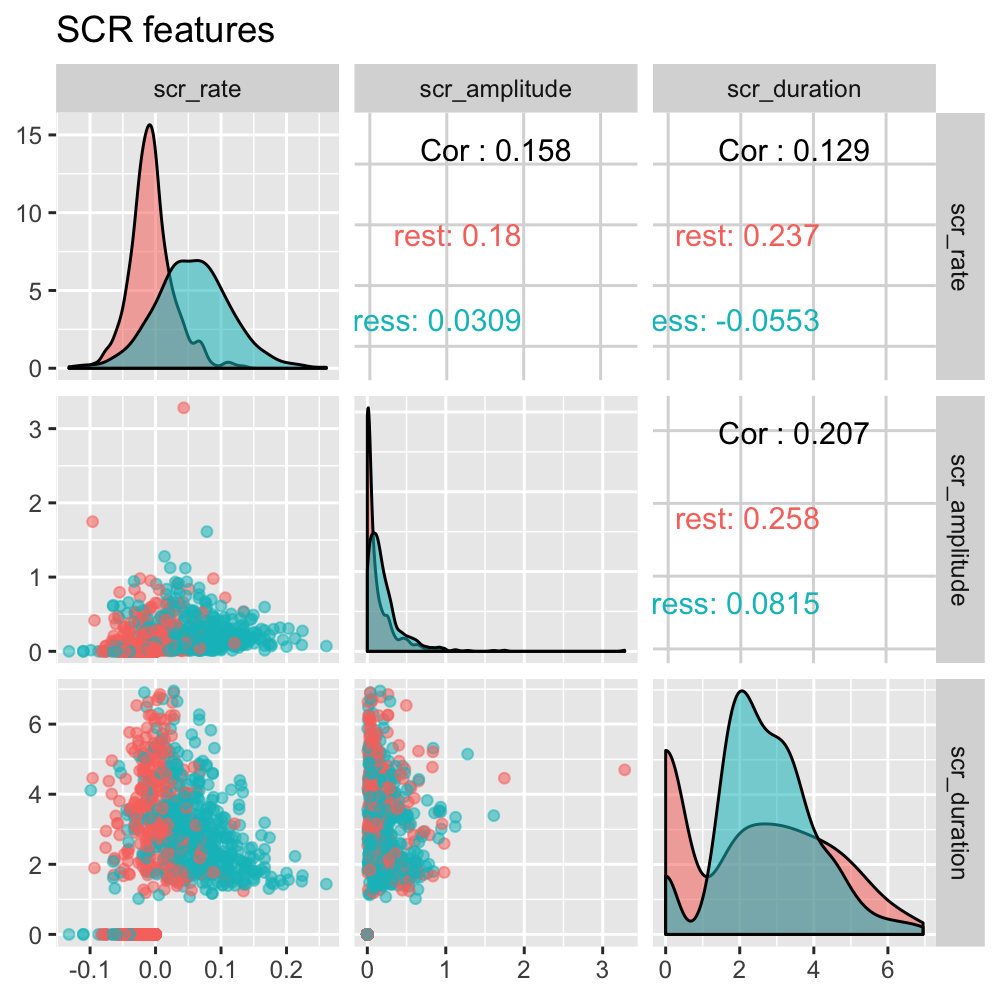

In [19]:
%%R -i df_train  -w 5 -h 5 --units in -r 200
# Change column order
columns = c('scr_rate', 'scr_amplitude', 'scr_duration', 'sequence_label')
tmp = df_train[columns]
ggpairs(tmp, 
    title='SCR features', 
    columns=1:3,
    mapping=aes(colour=sequence_label, alpha=.3), 
    progress=FALSE) 

Visually, it seams that scr_rate itself can separate the two conditions.  It should be notted that the 0.0 values in scr_amplitude and scr_duration are due to the observation where no SCR peak could be detected. Indeed, the scr_rate has been 'baseline-corrected', which exlpains that we observe negattive rate (relative to the pseudo-baseline period) 

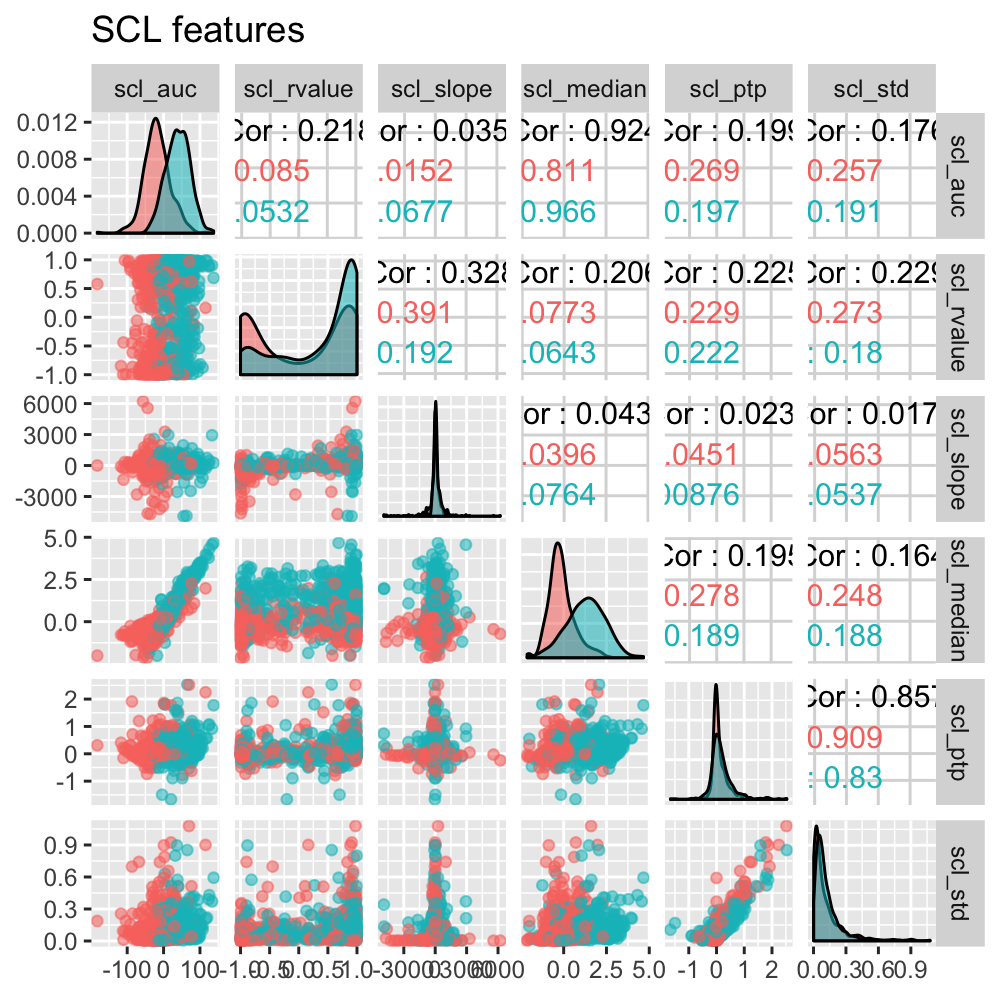

In [20]:
%%R -i df_train  -w 5 -h 5 --units in -r 200
# Change column order
columns = c('scl_auc', 'scl_rvalue', 'scl_slope', 'scl_median', 'scl_ptp', 'scl_std', 'sequence_label')
tmp = df_train[columns]
ggpairs(tmp, 
    title='SCL features', 
    columns=1:6,
    mapping=aes(colour=sequence_label, alpha=.3), 
    progress=FALSE) 

Visually, it seams that scl_auc and scl_median are very discriminant against the two conditions. It should be notted that those are extremely correlated, which is not desirable when fitting a model. 

In [21]:
# create a helper class to allow storing variables with same names for the different analysis 
class PencilCase():
    ''' Helper class to store stuffs'''
    def __init__(self, name=None):
        self._name = name

estimate_activation = PencilCase('train_activation')
estimate_activation.scr = PencilCase('scr')
estimate_activation.scl = PencilCase('scl')
estimate_activation.df_train = df_train
estimate_activation.df = df

Here, we use a logistic regression with a cross-validation on the choice of Cs and l1_ratios values. This is equivalent to selecting the best features before fitting the logistic regression model. <br>
The 'no go' threshold to validate the approach was to obtain a discirmination roc_auc greater than 0.75. We got 0.84 and 0.89 with a cross-valdiation with 10 folds. <br>



<div class="alert alert-info">
Here, we scale the data using a StandardScaler, even though some distributions are clearly biased (eg. src_amplitude and scr_duration have lot's of 0.0 values). This results in variations in the features ranges. <br>
--> Baseline correction of those?
</div>

<div class="alert alert-info">
Surveys used as 'rest' state are also used in the estimation of the pseudo-baseline, so contributed to the correction, which could result in biasing those features. <br> 
--> Use a different baseline correction   
</div>


In [22]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegressionCV

model =  LogisticRegressionCV(Cs=np.logspace(-6, 6, base=10, num=20), fit_intercept=True,
                                                cv=10, dual=False, penalty='l1', 
                                                scoring='roc_auc', solver='liblinear', 
                                                tol=0.0001, max_iter=100,
                                                class_weight=None, 
                                                n_jobs=None, 
                                                verbose=0, 
                                                refit=True, 
                                                intercept_scaling=1.0,
                                                random_state=None, l1_ratios=None)
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()

In [23]:
case = estimate_activation.scl
case.features = ['scl_auc', 'scl_rvalue', 'scl_slope', 'scl_median', 'scl_ptp', 'scl_std']
#case.features = ['scl_median']
df = df_train[case.features + ['context']]
case.X = df.values[:,:-1]
case.X_scaled = scaler.fit_transform(case.X)
case.y = df.values[:,-1]
case.df = df
df.head()

scl_auc  scl_rvalue   scl_slope  scl_median   scl_ptp   scl_std  context
3    3.662503    0.562868  277.439529    0.123232  0.138669  0.105200        0
17 -43.129275   -0.980808 -795.194419   -1.249285 -0.194201  0.011190        0
41  61.522127    0.416935  165.795481    1.337690  0.612532  0.221420        1
46  43.937279   -0.930322   36.515140    1.337703 -0.032427  0.077289        1
60   2.931992   -0.237642  567.457345    0.083633  0.013033  0.007666        1

In [24]:
case = estimate_activation.scr
case.features = ['scr_rate', 'scr_amplitude', 'scr_duration']
# case.features = ['scr_rate']

df = df_train[case.features + ['context']]
case.X = df.values[:,:-1]
case.X_scaled = scaler.fit_transform(case.X)
case.y = df.values[:,-1]
case.df = df
df.head()

scr_rate  scr_amplitude  scr_duration  context
3  -0.018432       0.244139      2.265523        0
17 -0.074933       0.000000      0.000000        0
41  0.011898       0.253671      3.513514        1
46  0.025074       0.180416      3.835765        1
60  0.066695       0.024212      6.271219        1

In [25]:
from copy import copy
# KFold/StratifiedKFold cross validation with 10 folds 
def train_activation_model(case): 
    print(f'Training activation model for {case._name}')
    print('-'*35)
    cv_score = cross_validate(model, case.X_scaled, case.y, cv=10, scoring=['accuracy', 'roc_auc'])
    for s, vals in cv_score.items():
        print(f'{s} = {vals.mean():.2f} +/- {vals.std():.2f}')

    fitted_model = model.fit(case.X_scaled, case.y)
    case.features_coef = pd.DataFrame(fitted_model.coef_.ravel(), index=case.features, columns=['coef'])
    case.model = copy(fitted_model)
    print(case.features_coef)
    print('_'*100)
    
train_activation_model(estimate_activation.scr)
train_activation_model(estimate_activation.scl)

Training activation model for scr
-----------------------------------
fit_time = 0.23 +/- 0.02
score_time = 0.00 +/- 0.00
test_accuracy = 0.78 +/- 0.02
test_roc_auc = 0.84 +/- 0.02
                   coef
scr_rate       1.656170
scr_amplitude  0.162996
scr_duration   0.063566
____________________________________________________________________________________________________
Training activation model for scl
-----------------------------------
fit_time = 0.29 +/- 0.01
score_time = 0.00 +/- 0.00
test_accuracy = 0.81 +/- 0.05
test_roc_auc = 0.89 +/- 0.03
                coef
scl_auc     2.040921
scl_rvalue  0.405952
scl_slope   0.071794
scl_median  0.000000
scl_ptp     0.000000
scl_std    -0.414176
____________________________________________________________________________________________________


The cross-validated roc_auc scores being good, we validate the approach and estimate the probability to be 'phasic-activated' and the probability to be 'tonic-activated'. 

<div class="alert alert-info">
    We are going to introduce a variable rename in favor of readability, as explained below.
</div>

**Variable rename list:**

* `SCL` will be used for the probability to be 'tonic-activated'
* `SCR` will be used for the probability to be 'phasic-activated'

In [26]:
case = estimate_activation.scr
df = estimate_activation.df[case.features]
valid_index = df.dropna().index
X = df.dropna().values

X_scaled = scaler.fit_transform(X)
proba = case.model.predict_proba(X_scaled)[:,1]
case.proba_df = pd.DataFrame(proba, index=valid_index, columns=[case._name])

In [27]:
case = estimate_activation.scl
df = estimate_activation.df[case.features]
valid_index = df.dropna().index
X = df.dropna().values
X_scaled = scaler.fit_transform(X)
proba = case.model.predict_proba(X_scaled)[:,1]
case.proba_df = pd.DataFrame(proba, index=valid_index, columns=[case._name])

In [28]:
estimate_activation.proba_df = pd.concat([estimate_activation.df[['sequence', 'file_id', 'module', 'submodule', 'module_label', 'submodule_label']], 
                                          estimate_activation.scl.proba_df, 
                                          estimate_activation.scr.proba_df], axis=1)
estimate_activation.proba_df.head()

sequence  \
0                   physio-sonification_playground_0   
1  common_respiration-calibration_data-accumulati...   
2                         cardiac-coherence_survey_0   
3                         cardiac-coherence_survey_1   
4                                   intro_sequence_0   

                                file_id               module  \
0  c4bc0119-1a92-47ed-b8b8-3c2189834e75  physio-sonification   
1  c4bc0119-1a92-47ed-b8b8-3c2189834e75               common   
2  c4bc0119-1a92-47ed-b8b8-3c2189834e75    cardiac-coherence   
3  c4bc0119-1a92-47ed-b8b8-3c2189834e75    cardiac-coherence   
4  c4bc0119-1a92-47ed-b8b8-3c2189834e75                intro   

                 submodule  module_label  submodule_label       scl       scr  
0               playground             5               14  0.066800  0.048919  
1  respiration-calibration             2               15  0.698833  0.557775  
2                   survey             1               19  0.659494  0.148374  
3                   survey             1               19  0.609986  0.310004  
4                 sequence             3               18  0.719846  0.397153

### Relationship between phasic and tonic activation

In [29]:
#estimate_activation.proba_df.plot.scatter(x='scl_activation',y='scr_activation', colors=)
df_all = estimate_activation.proba_df
df_all = df_all[~df_all.submodule.isin(['sequence'])]
df_all = df_all[~df_all.module.isin(['session', 'common', 'lobby', 'intro'])]
df_ss = df_all[df_all.module == 'space-stress']
df_coh = df_all[df_all.module == 'cardiac-coherence']
df_son = df_all[df_all.module == 'physio-sonification']

Let us quantify if 'tonic-activation' goes together with 'phasic-activation'. We set 0.5 as threshold for the probability to be considered 'activated' and we *count* how many times we observe a phasic together with tonic activation, or on the contrary without. 

In [30]:
df = df_all.dropna()
R_noL = len(df_all[(df_all.scr>.5) & (df_all.scl<.5)])/len(df)
R_L = len(df_all[(df_all.scr>.5) & (df_all.scl>.5)])/len(df)
noR_noL = len(df_all[(df_all.scr<.5) & (df_all.scl<.5)])/len(df)
L_noL = len(df_all[(df_all.scr<.5) & (df_all.scl>.5)])/len(df)
print("Observation of phasic together with tonic: %8.2f percent. "% (R_L*100))
print("Observation of no tonic and no phasic : %8.2f percent. "% (noR_noL*100))
print("Observation of tonic without phasic: %8.2f percent. "% (L_noL*100))
print("Observation of phasic without tonic: %8.2f percent. "% (R_noL*100))

Observation of phasic together with tonic:    46.56 percent. 
Observation of no tonic and no phasic :    27.81 percent. 
Observation of tonic without phasic:    18.24 percent. 
Observation of phasic without tonic:     7.39 percent. 


/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


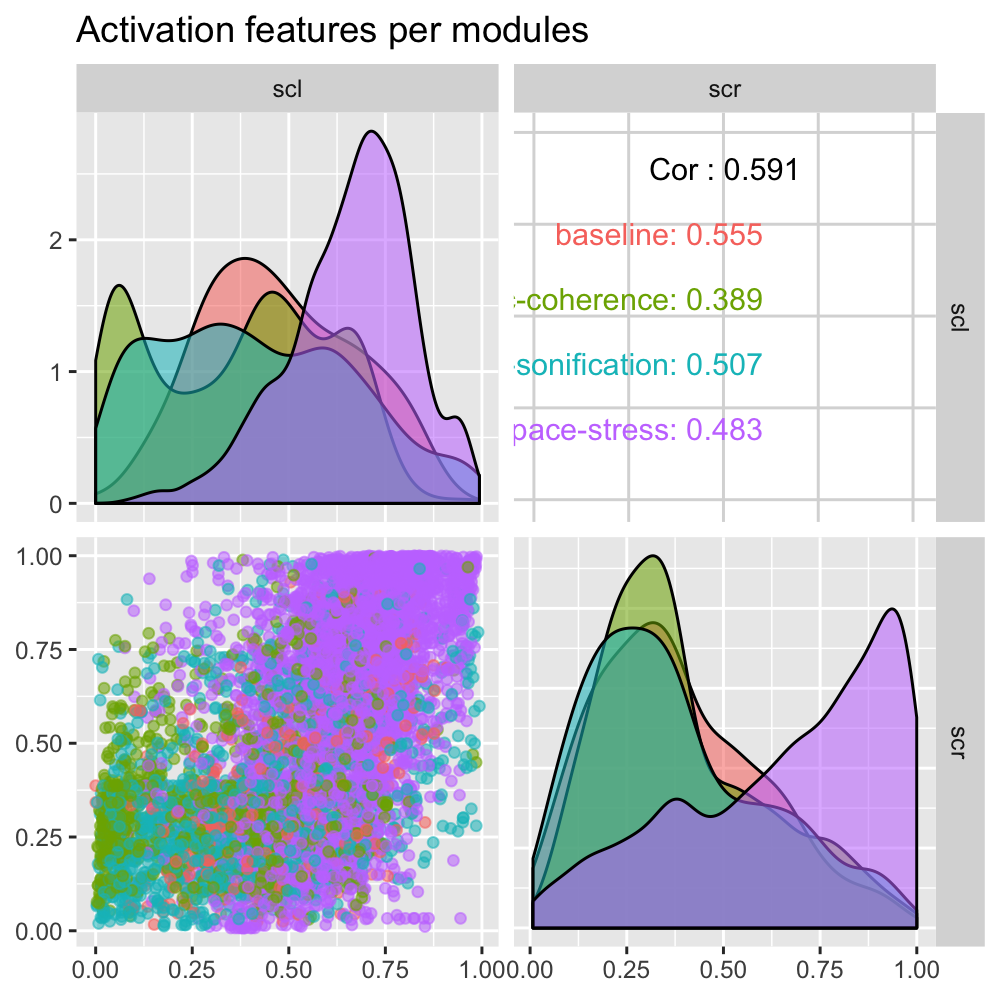

In [31]:
%%R -i df_all  -w 5 -h 5 --units in -r 200
columns = c('scl', 'scr', 'module')
tmp = df_all[columns]
head(tmp)
ggpairs(tmp, 
    title='Activation features per modules', 
    columns=1:2,
    mapping=aes(colour=module, alpha=.3), 
    progress=FALSE) 

In 75% of the observations, a tonic activation (resp. decompression) goes together with a phasic activation (resp decompression). The correlation between probability to be tonic-activated or phasic-activated is of 0.5. 

### Activations against experiment context 
#### Activations against modules and submodules

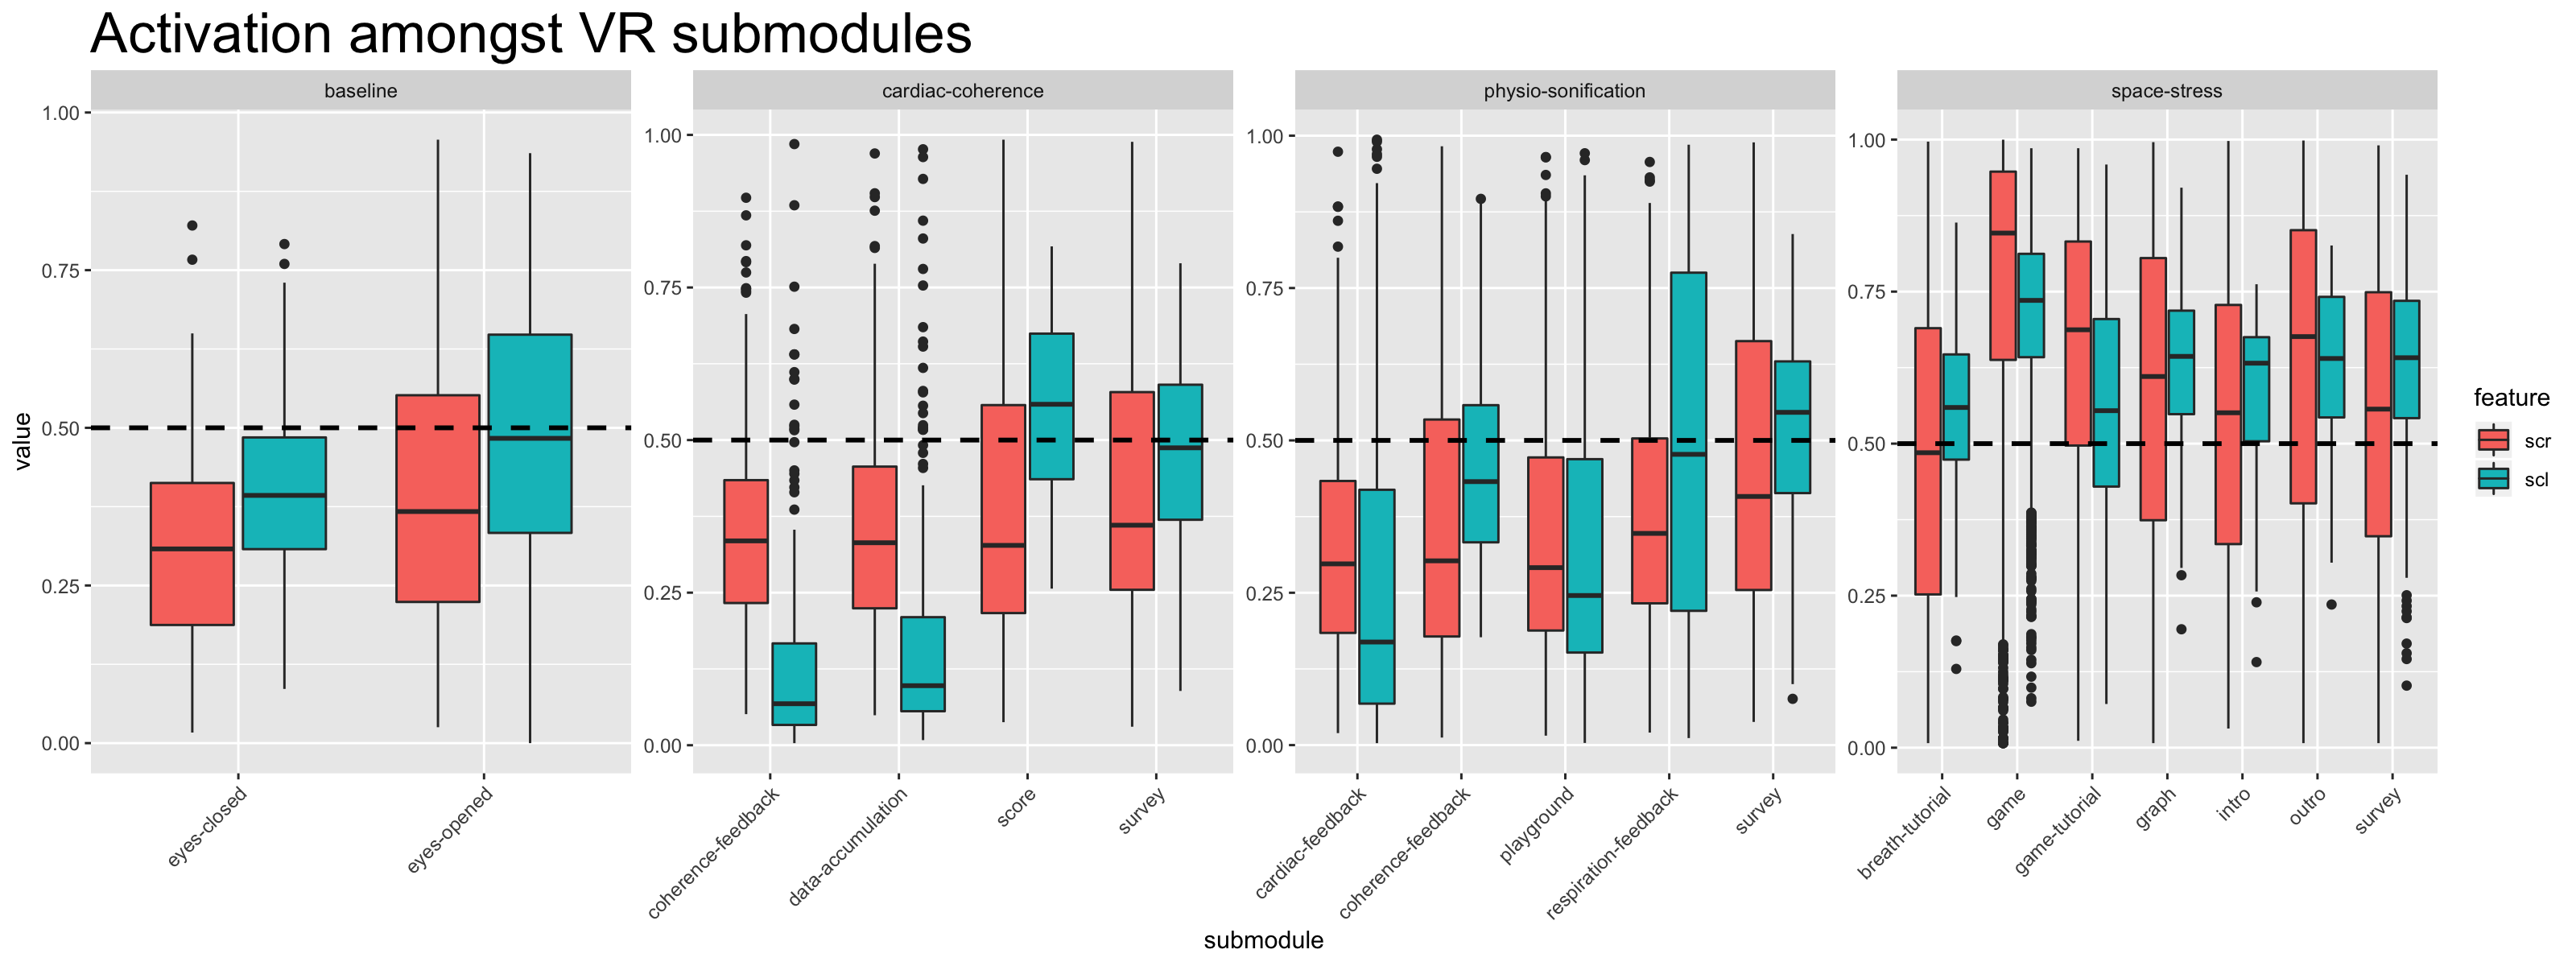

In [32]:
%%R -i df_all -w 16 -h 6 --units in -r 200

columns = c('scl', 'scr', 'module', 'submodule')
tmp = df_all[columns]
tmp = reshape::melt(tmp,
                        id.vars=c('module', 'submodule'),
                        measure.vars=c('scr', 'scl'),
                        variable_name='feature')

g1 = ggplot(tmp, aes(x=submodule, y=value, fill=feature)) +
    geom_boxplot()+
    geom_hline(yintercept=.5, linetype='dashed', size=1, color='black')+
    facet_wrap(.~module, ncol=4, scales='free') +
    labs(title="Activation amongst VR submodules", size=25) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title=element_text(size=25))
g1

Here, we check that the model has not overfitted. <br>
Hence, we fitted the model on 2 surveys and 2 waves and we clearly see that observation during space-stress game are activated (probability greater than .5) , whereas observation during baselines and relaxing modules are not (probability lower than .5). 

In [33]:
# let us now zoom on space-stress 
df_ss = df_all[df_all.module=='space-stress']
df_ss.loc[:, 'sequence_short'] = df_ss.sequence.str.replace('space-stress_', '', 1).str.replace('game_enemy-', '', 1)

/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


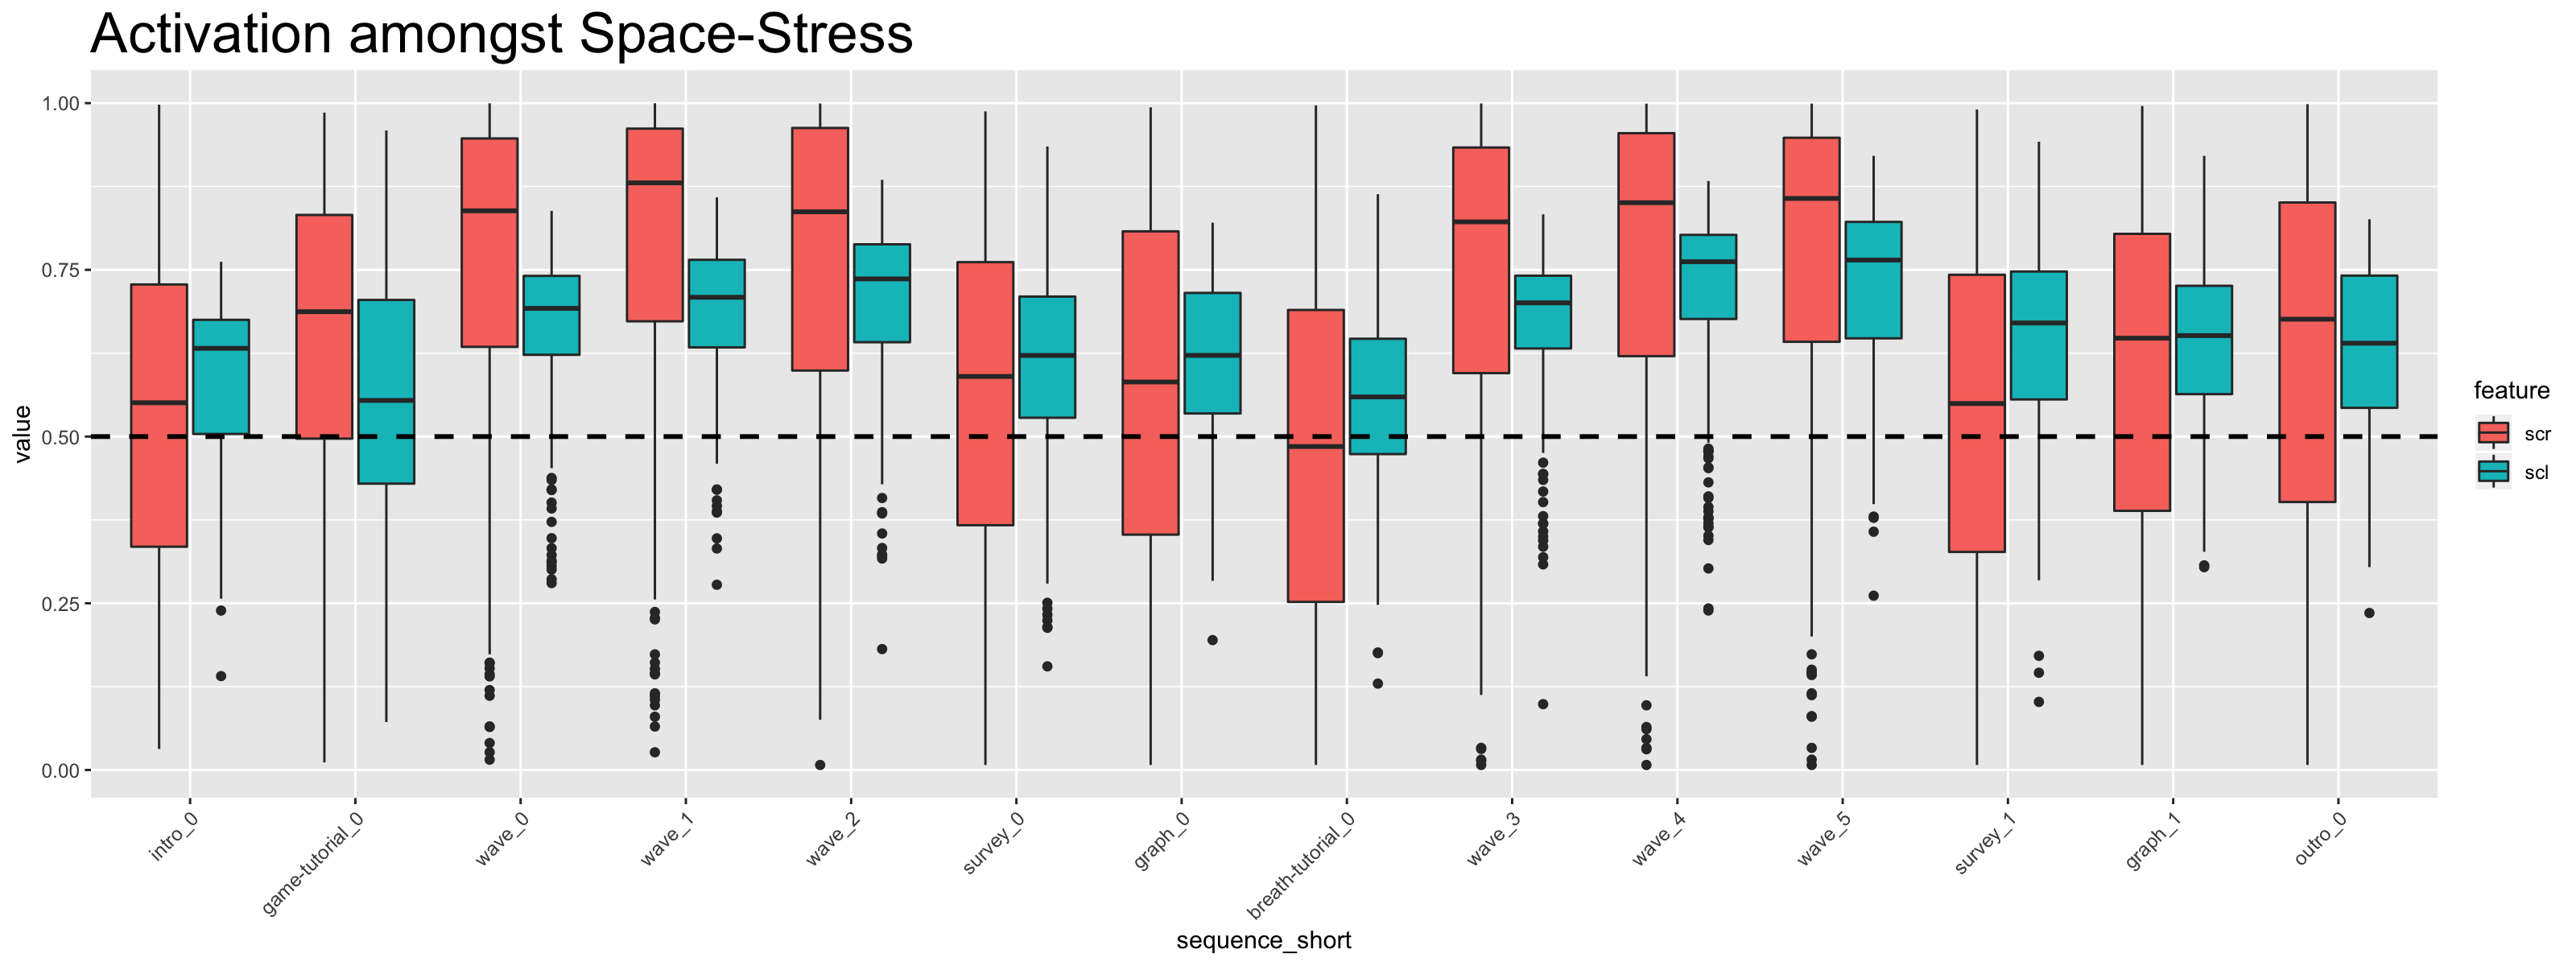

In [34]:
%%R -i df_ss -w 16 -h 6 --units in -r 200

columns = c('scr', 'scl', 'sequence_short')
tmp = df_ss[columns]

tmp = reshape::melt(tmp,
                        id.vars=c('sequence_short'),
                        measure.vars=c('scr', 'scl'),
                        variable_name='feature')

g1 = ggplot(tmp, aes(x=sequence_short, y=value, fill=feature)) +
    geom_boxplot()+
    geom_hline(yintercept=.5, linetype='dashed', size=1, color='black')+
    scale_x_discrete(limits=c('intro_0',
                              'game-tutorial_0', 
                              'wave_0', 'wave_1', 'wave_2',
                              'survey_0','graph_0', 
                              'breath-tutorial_0',
                              'wave_3', 'wave_4', 'wave_5', 
                              'survey_1', 'graph_1', 
                              'outro_0')) + 
    labs(title="Activation amongst Space-Stress") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title=element_text(size=25))
g1

Here, we observe that, on average, the participan during space-stress are highly activated during the 6 waves, and less during the surveys, graphs and tutorials. <br>
It should be notted that the phasic-activation seems more variable across participant than the tonic-activation. 

In [35]:
space_stress_sequences = {
    # sequence name:                  category order
  # 'game_0':    0,
 #  'game_1':    2,
  # 'survey_0':  1,
  # 'survey_1':    3,
    'game-tutorial_0':    0,
    'wave_0':             1,
    'wave_1':             2,
    'wave_2':             3,
    'survey_0':           4,
    'breath-tutorial_0':  5,
    'wave_3':             6,
    'wave_4':             7,
    'wave_5':             8,
    'survey_1':           9,
}
df_ss = df_ss[df_ss.sequence_short.isin(space_stress_sequences)]
df_ss['context'] = df_ss.sequence_short.apply(lambda s: space_stress_sequences[s])


df_ss.head()

sequence                               file_id  \
6   space-stress_breath-tutorial_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
7            space-stress_survey_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
8            space-stress_survey_1  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
25    space-stress_game-tutorial_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
41  space-stress_game_enemy-wave_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   

          module        submodule  module_label  submodule_label       scl  \
6   space-stress  breath-tutorial             7                0  0.716560   
7   space-stress           survey             7               19  0.622802   
8   space-stress           survey             7               19  0.552823   
25  space-stress    game-tutorial             7                9  0.913958   
41  space-stress             game             7                8  0.744292   

         scr     sequence_short  context  
6   0.208875  breath-tutorial_0        5  
7   0.367154           survey_0        4  
8   0.048919           survey_1        9  
25  0.570064    game-tutorial_0        0  
41  0.566946             wave_0        1

#### Activation against space-stress difficulty 

In [36]:
df_ss_merged = df_ss.merge(df_ss_beh, on=['file_id', 'sequence'], how='right', 
            left_index=False, right_index=False)
df = df_ss_merged
df_ss_merged.head()

sequence                               file_id  \
0           space-stress_survey_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
1           space-stress_survey_1  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
2  space-stress_game_enemy-wave_0  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
3  space-stress_game_enemy-wave_1  c4bc0119-1a92-47ed-b8b8-3c2189834e75   
4  space-stress_game_enemy-wave_2  c4bc0119-1a92-47ed-b8b8-3c2189834e75   

         module submodule  module_label  submodule_label       scl       scr  \
0  space-stress    survey           7.0             19.0  0.622802  0.367154   
1  space-stress    survey           7.0             19.0  0.552823  0.048919   
2  space-stress      game           7.0              8.0  0.744292  0.566946   
3  space-stress      game           7.0              8.0  0.738504  0.687144   
4  space-stress      game           7.0              8.0  0.778386  0.704291   

  sequence_short  context  difficulty  accuracy  
0       survey_0      4.0    0.000000       NaN  
1       survey_1      9.0    0.000000       NaN  
2         wave_0      1.0    0.228881       3.0  
3         wave_1      2.0    0.648803       7.0  
4         wave_2      3.0    2.940192       9.0

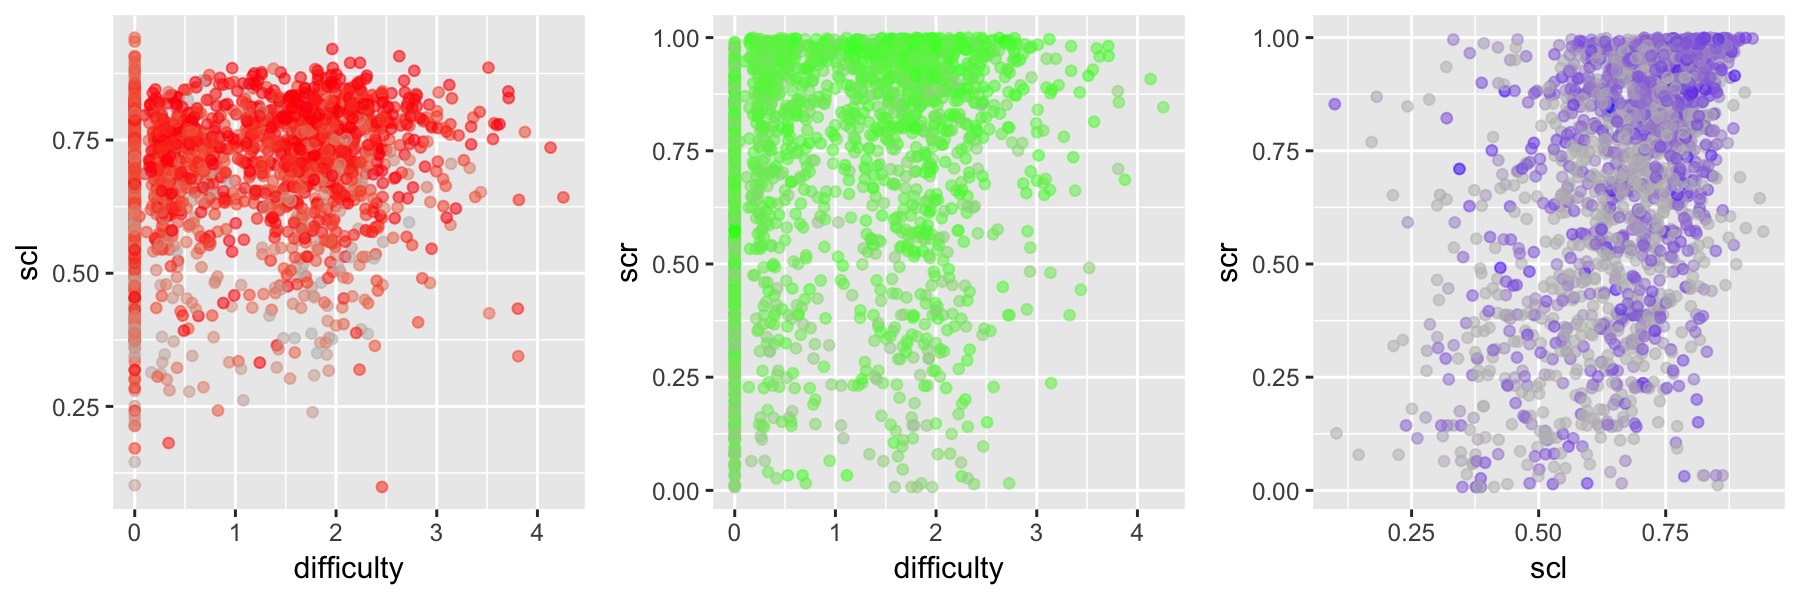

In [37]:
%%R -i df  -w 9 -h 3 --units in -r 200

g1 = ggplot(df, aes(x=difficulty, y=scl, color=scr, alpha=.2)) +
        geom_point() +
        scale_color_gradient(low='gray', high='red') + 
        theme(legend.position='up')
    
g2 = ggplot(df, aes(x=difficulty, y=scr, color=scl, alpha=.2)) +
geom_point() +
scale_color_gradient(low='gray', high='green') + 
theme(legend.position='up')

g3 = ggplot(df, aes(x=scl, y=scr, color=difficulty, alpha=.2)) +
geom_point() +
scale_color_gradient(low='gray', high='blue') + 
theme(legend.position='up')

cowplot::plot_grid(g1, g2, g3, nrow=1)

**Observations:**
- scr and scl are correlated during space-stress 
- no clear correlation pattern between scr/scl activations and the waves difficulty (at population level)

### Covariance dataset 
Here, we construct a dataset with variance/covariance of the tonic/phasic activations and the context (difficulty of the waves and 0.0 for the surveys). <br>
The purpose is to quantify how well a participant galvanic activations follows the context, ie. how 'apropriate' the activation is given the difficulty. 

In [38]:
def melt_cov(df):
    df_cov = df.cov()
    keep = np.triu(np.ones(df_cov.shape)).astype('bool').reshape(df_cov.size)
    df_cov_melt = df_cov.stack(dropna=False)[keep]
    df_cov_melt.index = df_cov_melt.index.to_list()
    return df_cov_melt

In [39]:
df_cov = (
    df_ss_merged[['scr', 'scl', 'file_id', 'difficulty']]
    .groupby('file_id')
    .apply(lambda d: melt_cov(d))
    .dropna()
        )
df_cov.iloc[:, :] = preprocessing.StandardScaler().fit_transform(df_cov)
df_cov.columns.name = 'cov'
df_cov.columns = [level[0] + '_' + level[1] for level in  list(df_cov.columns)]

df_cov.head()

scr_scr   scr_scl  scr_difficulty  \
file_id                                                                    
00393092-0674-4cba-8877-8c3733f410b9 -0.413480 -0.321111       -0.257297   
0203909d-aa3d-4803-b260-541f4fc825cb -0.929583 -0.714698       -1.201444   
04cec6c3-3f0c-49cc-a7c2-a9ba9e162ea7 -0.432038 -1.852168        0.131940   
09e7718c-e75a-4c73-990f-1db6153a4d10  1.905940 -0.026977        0.723619   
0ac4ce64-ee07-45a2-946f-072f509cbcdf -1.070566 -0.423529       -0.153965   

                                       scl_scl  scl_difficulty  \
file_id                                                          
00393092-0674-4cba-8877-8c3733f410b9 -0.589593       -1.412530   
0203909d-aa3d-4803-b260-541f4fc825cb -0.569413       -1.495017   
04cec6c3-3f0c-49cc-a7c2-a9ba9e162ea7 -0.215022       -1.047973   
09e7718c-e75a-4c73-990f-1db6153a4d10 -0.690295       -0.486348   
0ac4ce64-ee07-45a2-946f-072f509cbcdf -0.560144       -0.124970   

                                      difficulty_difficulty  
file_id                                                      
00393092-0674-4cba-8877-8c3733f410b9              -0.181986  
0203909d-aa3d-4803-b260-541f4fc825cb               0.637064  
04cec6c3-3f0c-49cc-a7c2-a9ba9e162ea7              -0.577947  
09e7718c-e75a-4c73-990f-1db6153a4d10              -1.391667  
0ac4ce64-ee07-45a2-946f-072f509cbcdf              -0.452869

### Exploratory plots

## Method

We now have 4 datasets: 
- scl: dimension 8, with phasic activations during the 6 space-stress waves and the 2 surveys 
- scr: dimension 8, with tonic activations during the 6 space-stress waves and the 2 surveys 
- sc: dimension 16, with both tonic and phasic activations during the 6 space-stress waves and the 2 surveys 
- cov: dimension 6 with the variances and covariances between physio activation (SCR and SCL) and the context (space-stress difficulty). 

The aim is to see if we can draw clusters/profiles out of those datasets. 

<div class="alert alert-info">
One difficulty here is to scale the dataset without disturbing the vector order (ie. for each feature, the order of the activation across the 6 space-stress periods must remain the same). <br>
Here, we fit the standard scaler for each dimension of the entire dataset and we then transform each column with the same parameters, so that the 'shapes' of each vector is conserved.  
</div>


### Exploratory dimension reduction

On this section, we would like to reduce each dataset to 2 dimensions and quantify how good this projection is. 
If a projection in a reduced space is explicative and we can see some spatial structure (clusters, groups, ...), 
then this would solve the problem of this notebook.

#### PCA

A PCA for the SCL dataset explains a lot of variability in two projected dimensions. 
However, there is no evident spatial structure: one cannot clearly draw or guess that there are clusters of data.

In [40]:
def scale_df(df):
    ''' Scales a dataframe by fitting on all the data'''
    scaler = preprocessing.StandardScaler()
    scaler.fit(df.stack().values.reshape(-1, 1))
    df_scaled = df.apply(lambda col: scaler.transform(col.values.reshape(-1,1))[:,0])
    return df_scaled 

In [41]:
profiling = PencilCase('train_activation')

profiling.df_ss = df_ss

profiling.scr = PencilCase('scr')
profiling.scl = PencilCase('scl')
profiling.sc = PencilCase('sc')
profiling.cov = PencilCase('cov')

sequences_short = ['survey_0', 'survey_1', 
                  # 'game_0', 'game_1']
                   'wave_0',  'wave_1',  'wave_2',
                   'wave_3',  'wave_4',  'wave_5']

for case, values in zip([profiling.scl, profiling.scr], 
                          [['scl'], ['scr']]):
    case.df = (
    df_ss[df_ss.sequence_short.isin(sequences_short)].pivot(columns='sequence_short', values=values, index='file_id')
    .dropna(how='any')
)
    case.df = scale_df(case.df)
    #case.df.iloc[:,:] = preprocessing.StandardScaler().fit_transform(case.df)
    case.X = case.df.values
    case.df.columns = [level[0] + '_' + level[1] for level in  list(case.df.columns)]

profiling.sc.df = pd.concat([profiling.scl.df, profiling.scr.df], axis=1, sort=True).dropna()
profiling.sc.df.index.name = 'file_id'
profiling.sc.X = profiling.sc.df.values

profiling.cov.df = df_cov
profiling.cov.df.iloc[:,:] = preprocessing.StandardScaler().fit_transform(df_cov)
profiling.cov.X = profiling.cov.df.values

In [42]:
from sklearn.decomposition import PCA


def biplot(x, coefs, labels=None, k=1, ax=None):
    """Utility function to plot PCA results
    
    Inspired from https://stackoverflow.com/a/46766116/227103
    """
    if ax is None:
        ax = plt.gca()

    n = coefs.shape[0]
    if labels is None:
        labels = [f'X{i}' for i in range(n)]

    xs = x[:, 0]
    ys = x[:, 1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    ax.scatter(xs * scalex, ys * scaley)

    for i in range(n):
        ax.arrow(0, 0, coefs[i, 0] * k, coefs[i, 1] * k, color='r', alpha=0.5)
        ax.text(coefs[i, 0] * k * 1.15, coefs[i, 1] * k * 1.15, labels[i], color='g',
                ha='center', va='center')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid()

Explained variance: [ 58.2140452   71.03925211  81.06570743  86.71312356  91.83534311
  95.49083423  98.07947772 100.        ]


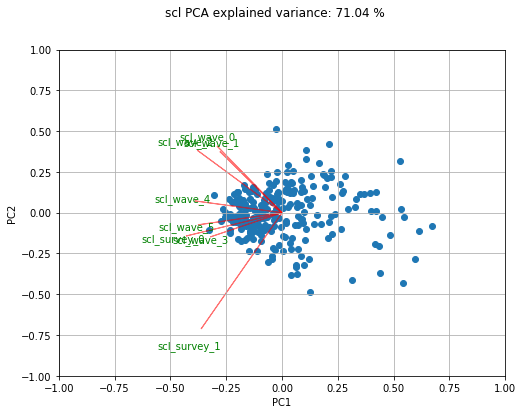

____________________________________________________________________________________________________
Explained variance: [ 51.35607466  64.53398081  73.45850788  80.04966465  85.99593153
  91.11296443  95.93134808 100.        ]


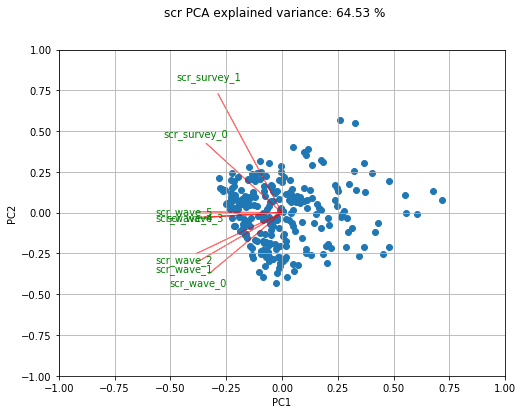

____________________________________________________________________________________________________
Explained variance: [ 43.52639019  55.61497296  65.47973797  71.83274155  75.83006166
  79.45071569  82.86801725  85.72564521  88.33112164  90.80508654
  93.04976383  94.89335812  96.6432926   98.04352429  99.18361231
 100.        ]


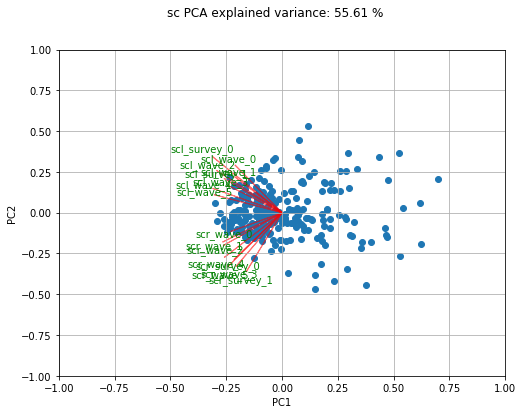

____________________________________________________________________________________________________
Explained variance: [ 42.77034157  64.58222113  78.25125375  87.11922212  94.67950909
 100.        ]


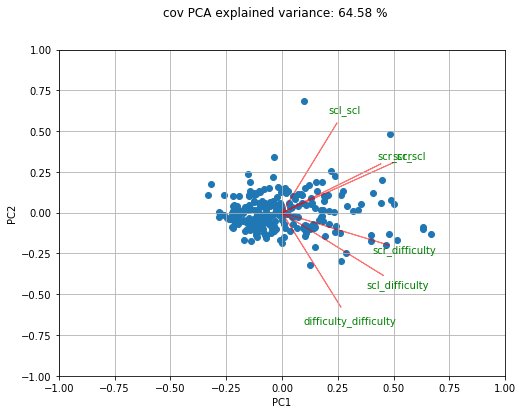

____________________________________________________________________________________________________


In [43]:
for case in [profiling.scl, profiling.scr, profiling.sc, profiling.cov]:
    X = case.X
    pca = PCA(n_components=X.shape[1]).fit(X)
    case.Xpca = pca.transform(X)
    pca_var = 100 * np.cumsum(pca.explained_variance_ratio_)
    print('Explained variance:', pca_var)
    plt.figure(figsize=(8,6))
    biplot(case.Xpca[:, 0:2], pca.components_[0:2, :].T, list(case.df.columns))
    plt.suptitle(f'{case._name} PCA explained variance: {pca_var[1]:.2f} %');
    plt.show()
    print('_'*100)

For the SCR dataset, the PCA projection on 2 dimension explains less variability. 
We could have expected this from the pair plot and lack of strong correlations in the previous section.
There is still no clear spatial structure or clusters.

#### TSNE

Since PCA was inconclusive, let us try to project to a manifold using t-SNE. 
Keep in mind that we cannot use the projected space for anything else (like clustering).


For the SCR dataset, there *might* be two modalities, one on the top left and the other one on the bottom right of the projected space.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 247 samples in 0.001s...
[t-SNE] Computed neighbors for 247 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 247 / 247
[t-SNE] Mean sigma: 0.838586
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.799480
[t-SNE] KL divergence after 1000 iterations: 0.582971


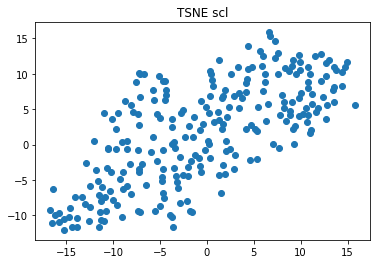

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 247 samples in 0.000s...
[t-SNE] Computed neighbors for 247 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 247 / 247
[t-SNE] Mean sigma: 0.938444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.619778
[t-SNE] KL divergence after 1000 iterations: 0.708573


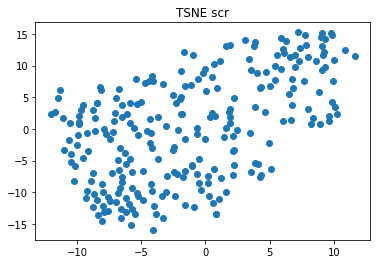

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 247 samples in 0.000s...
[t-SNE] Computed neighbors for 247 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 247 / 247
[t-SNE] Mean sigma: 1.311393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.907051
[t-SNE] KL divergence after 1000 iterations: 0.800520


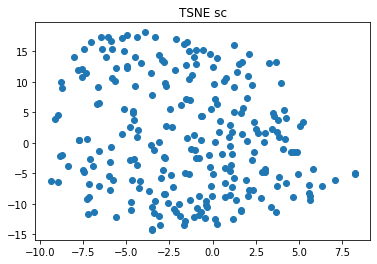

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 243 samples in 0.000s...
[t-SNE] Computed neighbors for 243 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 243 / 243
[t-SNE] Mean sigma: 0.836097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.733318
[t-SNE] KL divergence after 850 iterations: 0.661449


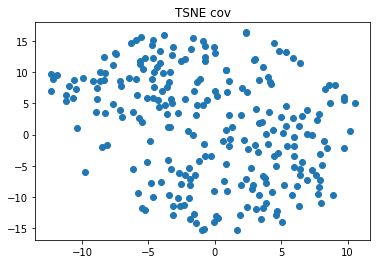

In [44]:
from sklearn.manifold import TSNE

for case in [profiling.scl, profiling.scr, profiling.sc, profiling.cov]: 
#for case in [profiling.test]: 
    tsne = TSNE(n_components=2, metric='euclidean', 
                verbose=True, random_state=42)
    case.Xtsne = tsne.fit_transform(case.X)
    plt.plot(case.Xtsne[:, 0], case.Xtsne[:, 1], 'o')
    plt.title(f'TSNE {case._name}')
    plt.show()

The spatial structure of the SCR dataset is less prominent or clear, but there *might* be two groups and many points between them.

#### Exploratory analysis concluding remarks

Using pair plots and PCA, we learned that:

* The SCL dataset has some strong correlations and these are captured by PCA.
* A PCA projection in 2 dimensions does not reveals an underlying structure of the datasets.
* Two PCA projected dimensions is not enough when considering the SCR feature.
* There does not seem to be a strong reason to PCA-transform our datasets

While on a manifold projection, we learned that:

* The SCL *might* have some non-linear structure, but this could be a *false idea* introduced by tSNE magic.
* When using SCR, the structure is less clear, yet there may be two main modes with many observations in between.


### Clustering

Let's try to calculate/extract some clusters from the datasets to see if we can find some spatial structure.

#### Preliminary verification

Before we go about clustering everything, we have to check a no-go condition here:
since we are working on high-dimensional data (6 dimensions on COV, 8 dimensions on SCL or SCR, and 16 on the combined case),
it is important to verify that the data points are not scattered very far away from each other.

Examining the histograms of all pairwise distances, we can see that:
* There is no red flag on the distances between points; even when we added more features, the points are not exaggerately far away.

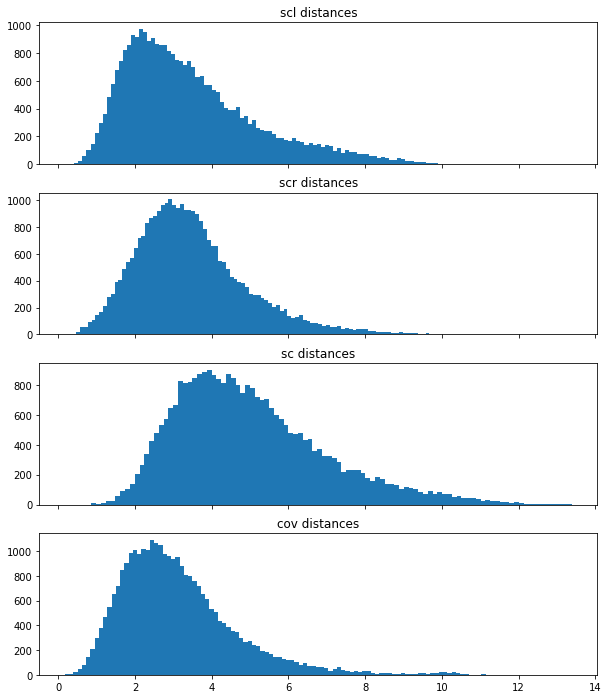

In [45]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import skew, kurtosis

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,12))

for k, case in enumerate([profiling.scl, profiling.scr, profiling.sc, profiling.cov]):
    case.dist = pdist(case.X, metric='euclidean')
    axs[k].hist(case.dist, bins=100)
    axs[k].set_title(f'{case._name} distances')

#### Affinity propagation

I decided to use affinity propagation clustering because the scikit-learn documentation has the following 
manifest on clustering analysis:

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="15%">
<col width="16%">
<col width="20%">
<col width="27%">
<col width="22%">
</colgroup>
<thead valign="bottom">
<tr class="row-odd"><th class="head">Method name</th>
<th class="head">Parameters</th>
<th class="head">Scalability</th>
<th class="head">Usecase</th>
<th class="head">Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even"><td><a class="reference internal" href="#k-means"><span class="std std-ref">K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large <code class="docutils literal"><span class="pre">n_samples</span></code>, medium <code class="docutils literal"><span class="pre">n_clusters</span></code> with
<a class="reference internal" href="#mini-batch-kmeans"><span class="std std-ref">MiniBatch code</span></a></td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#affinity-propagation"><span class="std std-ref">Affinity propagation</span></a></td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#mean-shift"><span class="std std-ref">Mean-shift</span></a></td>
<td>bandwidth</td>
<td>Not scalable with <code class="docutils literal"><span class="pre">n_samples</span></code></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#spectral-clustering"><span class="std std-ref">Spectral clustering</span></a></td>
<td>number of clusters</td>
<td>Medium <code class="docutils literal"><span class="pre">n_samples</span></code>, small <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Ward hierarchical clustering</span></a></td>
<td>number of clusters or distance threshold</td>
<td>Large <code class="docutils literal"><span class="pre">n_samples</span></code> and <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Agglomerative clustering</span></a></td>
<td>number of clusters or distance threshold, linkage type, distance</td>
<td>Large <code class="docutils literal"><span class="pre">n_samples</span></code> and <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#dbscan"><span class="std std-ref">DBSCAN</span></a></td>
<td>neighborhood size</td>
<td>Very large <code class="docutils literal"><span class="pre">n_samples</span></code>, medium <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#optics"><span class="std std-ref">OPTICS</span></a></td>
<td>minimum cluster membership</td>
<td>Very large <code class="docutils literal"><span class="pre">n_samples</span></code>, large <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Non-flat geometry, uneven cluster sizes, variable cluster density</td>
<td>Distances between points</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="mixture.html#mixture"><span class="std std-ref">Gaussian mixtures</span></a></td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#birch"><span class="std std-ref">Birch</span></a></td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <code class="docutils literal"><span class="pre">n_clusters</span></code> and <code class="docutils literal"><span class="pre">n_samples</span></code></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>

Our knowledge on this problem is:

* We do not know how many clusters there are.
* The number of observations per cluster is probably uneven.
* No knowledge on the geometry.

Therefore, I decided to use affinity propagation. I discarded K-means because of the unknown number of clusters and uneven cluster size. Mean-shift may be a interesting perspective. All the other ones were discarded for simplicity, lack of time, a to avoid a *use them all* approach.

The following sections will apply the following procedure:

1. Do a parameter search with cross validation for the sample preference model parameter 
  (the damping parameter was not included; it was fixed since there were 
  no convergence warnings with its default value, but this may be worth a reconsideration).
2. Plot the parameter search results and select a preference parameter with a good compromise/tradeoff
  between train/test clustering metric and cluster size.
3. Train the model with the whole data and the preference parameter to determine the clusters
  on the whole dataset.
4. Plot the points on projected spaces with the cluster results
5. Plot and comment on the distribution of the features of each cluster

The following cell tries to avoid repeating ourselves by creating some functions that will be applied on all datasets.

In [46]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold


def poormans_gridsearch(x):
    """Grid search the `preference` parameter of AffinityPropagation"""

    # A poor man's grid search
    preferences_param = np.arange(-500, 0, 10)
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    gs_results = []
    success = 0
    fail = 0
    for p in preferences_param:
        for i, (idx_train, idx_test) in enumerate(kfold.split(x)):
            try:
                x_train = x[idx_train]
                x_test = x[idx_test]
                model = AffinityPropagation(preference=p).fit(x_train)
                n_clusters = len(model.cluster_centers_indices_)
                labs_train = model.predict(x_train)
                score_train = silhouette_score(x_train, labs_train, metric='sqeuclidean')
                labs_test = model.predict(x_test)
                score_test = silhouette_score(x_test, labs_test, metric='sqeuclidean')
                gs_results.append({
                    'p': p,
                    'fold': i,
                    'n_clusters': n_clusters,
                    'score_train': score_train,
                    'score_test': score_test,
                })
                success += 1
            except ValueError:
                # fit/predict failed; ignore this particular fold dataset
                fail += 1
                
    if fail:
        print(f'Warning: grid search failed {fail} / {fail + success} times')
    df_gs = pd.DataFrame.from_records(gs_results)
    return df_gs


def plot_poormans(df, ref=None):
    """Plot the summarized results of :py:func:`poormans_gridsearch` """
    df_gs_group = df.groupby('p').agg({'mean', 'std'})
    plt.figure(figsize=(8*2, 6))
    plt.subplot(121)
    plt.plot(df_gs_group.index, df_gs_group[[('n_clusters', 'mean')]], label='# clusters')
    plt.fill_between(df_gs_group.index, 
                     np.ravel(df_gs_group[[('n_clusters', 'mean')]].values - df_gs_group[[('n_clusters', 'std')]].values),
                     np.ravel(df_gs_group[[('n_clusters', 'mean')]].values + df_gs_group[[('n_clusters', 'std')]].values),
                     alpha=0.5)
    if ref is not None:
        plt.axvline(ref, color='r', linestyle=':')
    plt.ylim(0, 10)
    plt.grid()
    plt.title('CV number of clusters')
    plt.legend()


    plt.subplot(122)
    plt.plot(df_gs_group.index, df_gs_group[[('score_train', 'mean')]], label='Train metric')
    plt.fill_between(df_gs_group.index, 
                     np.ravel(df_gs_group[[('score_train', 'mean')]].values - df_gs_group[[('score_train', 'std')]].values),
                     np.ravel(df_gs_group[[('score_train', 'mean')]].values + df_gs_group[[('score_train', 'std')]].values),
                     alpha=0.5)
    plt.plot(df_gs_group.index, df_gs_group[[('score_test', 'mean')]], label='Test metric')
    plt.fill_between(df_gs_group.index, 
                     np.ravel(df_gs_group[[('score_test', 'mean')]].values - df_gs_group[[('score_test', 'std')]].values),
                     np.ravel(df_gs_group[[('score_test', 'mean')]].values + df_gs_group[[('score_test', 'std')]].values),
                     alpha=0.5)
    if ref is not None:
        plt.axvline(ref, color='r', linestyle=':')
    plt.ylim(-1, 1)
    plt.grid()
    plt.title('CV scoring metric')
    plt.legend()
    
    
def train_affinity(x, preference, projections):
    af = AffinityPropagation(preference=preference).fit(x)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    counter = collections.Counter(labels)

    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"
          % silhouette_score(x, labels, metric='sqeuclidean'))
    print('Observations per cluster:', counter)
    
    cluster = [f'C{l}' for l in labels]
    cluster_details = [f'C{l} (n={counter[l]})' for l in labels]
    df_result = pd.DataFrame({'cluster': cluster, 'cluster_details': cluster_details})
    # Append columns with the features
    for i in range(x.shape[1]):
        df_result[f'x{i}'] = x[:, i]
        
    # also append columns of the features in a projected space
    if not isinstance(projections, dict):
        projections = {'p': projections}
    
    for k, proj in projections.items():
        for i in range(proj.shape[1]):
            df_result[f'x{k}{i}'] = proj[:, i]
    df_result.loc[:, 'cluster_master'] = False
    df_result.loc[af.cluster_centers_indices_, 'cluster_master'] = True

    return df_result

def post_cluster_merge(df_pre, df_post, df_full):
    assert df_pre.shape[0] == df_post.shape[0]
    df_tmp = df_pre.reset_index(drop=False)
    df_tmp['cluster'] = df_post['cluster']
    df_tmp['cluster_details'] = df_post['cluster_details']
    df_tmp['cluster_master'] = df_post['cluster_master']
    df_final = pd.merge(df_full, df_tmp[['file_id', 'cluster', 'cluster_details', 'cluster_master']], 
                        left_on='file_id', right_on='file_id')
    return df_final

In [47]:
profiling.scl.preference=-400  # 2 clusters, Silhouette Coefficient: 0.685
profiling.scr.preference=-300  # 2 clusters, Silhouette Coefficient: 0.604
profiling.sc.preference=-480  #  2 clusters, Silhouette Coefficient: 0.532    
profiling.cov.preference=-360  #  2 clusters, Silhouette Coefficient: 0.399

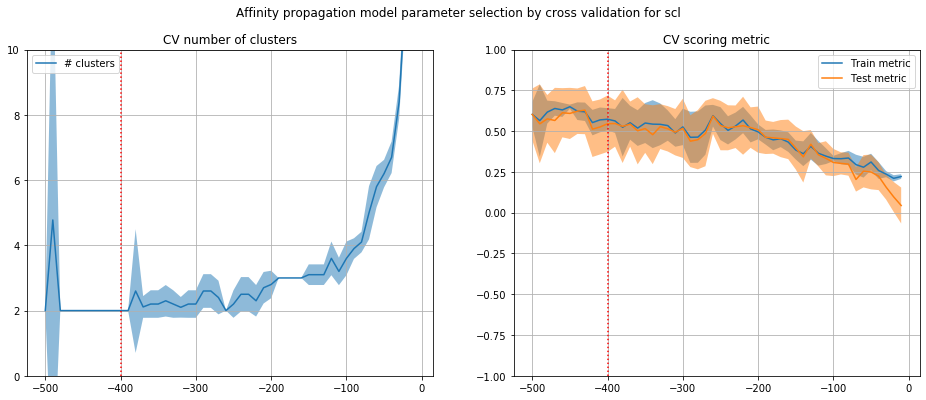

Estimated number of clusters: 2
Silhouette Coefficient: 0.648
Observations per cluster: Counter({0: 202, 1: 45})
____________________________________________________________________________________________________


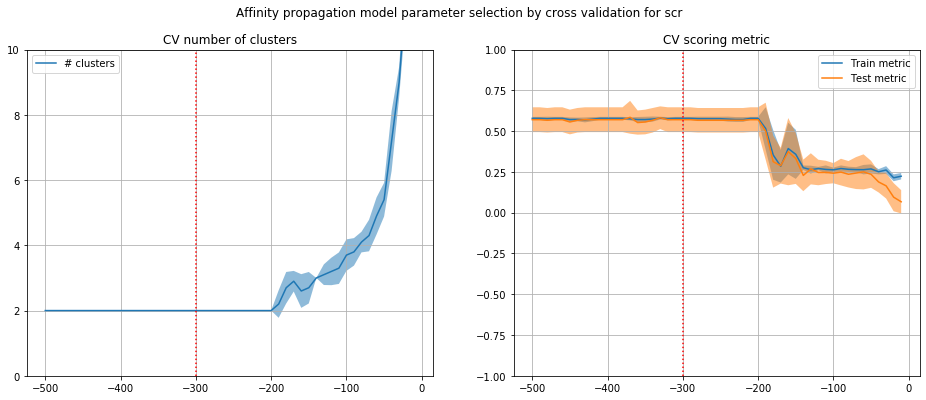

Estimated number of clusters: 2
Silhouette Coefficient: 0.580
Observations per cluster: Counter({0: 192, 1: 55})
____________________________________________________________________________________________________


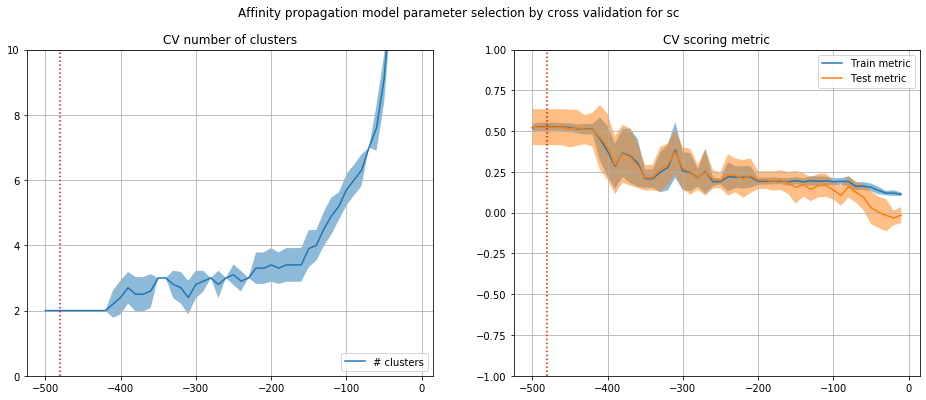

Estimated number of clusters: 2
Silhouette Coefficient: 0.487
Observations per cluster: Counter({1: 171, 0: 76})
____________________________________________________________________________________________________


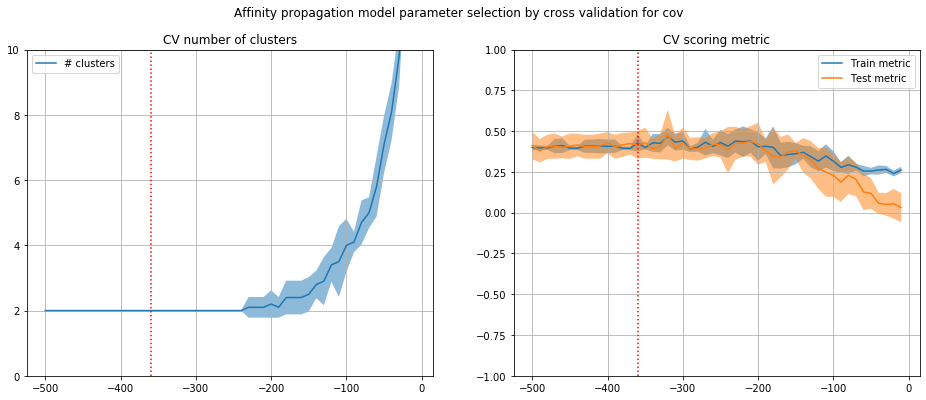

Estimated number of clusters: 2
Silhouette Coefficient: 0.509
Observations per cluster: Counter({0: 191, 1: 52})
____________________________________________________________________________________________________


In [48]:
for case in [profiling.scl, profiling.scr, profiling.sc, profiling.cov]: 
    case.df_gs = poormans_gridsearch(case.X)
    plot_poormans(case.df_gs, ref=case.preference)
    plt.suptitle(f'Affinity propagation model parameter selection by cross validation for {case._name}');
    plt.show()
    case.df_aff = train_affinity(case.X, case.preference, {'tsne':case.Xtsne, 'pca': case.Xpca})
    df_aff = case.df_aff
    case.df_complete = post_cluster_merge(case.df, case.df_aff, profiling.df_ss)
    df_complete = case.df_complete
    print('_'*100)

Preference values are chosen to be the best compromise: 
it is still where there is not train / test difference, the silhouette metric is high, the number of clusters is stable.

In [49]:
case = profiling.scl
df_aff = case.df_aff
df_complete = case.df_complete[case.df_complete.sequence_short.isin(sequences_short)]

/miniconda3/envs/gsr_sandbox-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


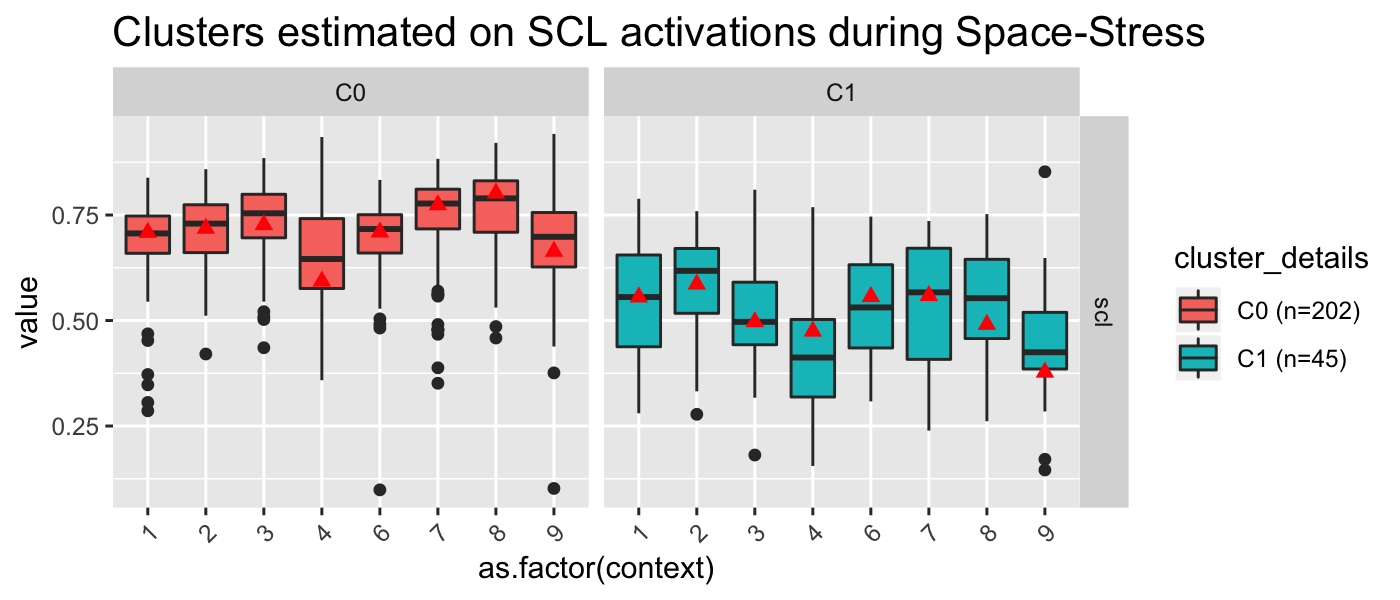

In [50]:
%%R -i df_complete -w 7 -h 3 --units in -r 200

tmp = reshape::melt(df_complete,
    id.vars=c('sequence', 'file_id', 'context', 'sequence_short', 'cluster', 'cluster_details', 'cluster_master'),
    measure.vars=c('scl'))

ggplot(tmp, aes(x=as.factor(context), y=value, fill=cluster_details)) +
    geom_boxplot() +
    geom_point(data=tmp[tmp$cluster_master,], 
               color=2, size=2, shape=17, show.legend=F) + 
facet_grid(variable~cluster, scales='free_y') +
labs(title="Clusters estimated on SCL activations during Space-Stress") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title=element_text(size=15))


In [51]:
case = profiling.scr
df_aff = case.df_aff
df_complete = case.df_complete[case.df_complete.sequence_short.isin(sequences_short)]

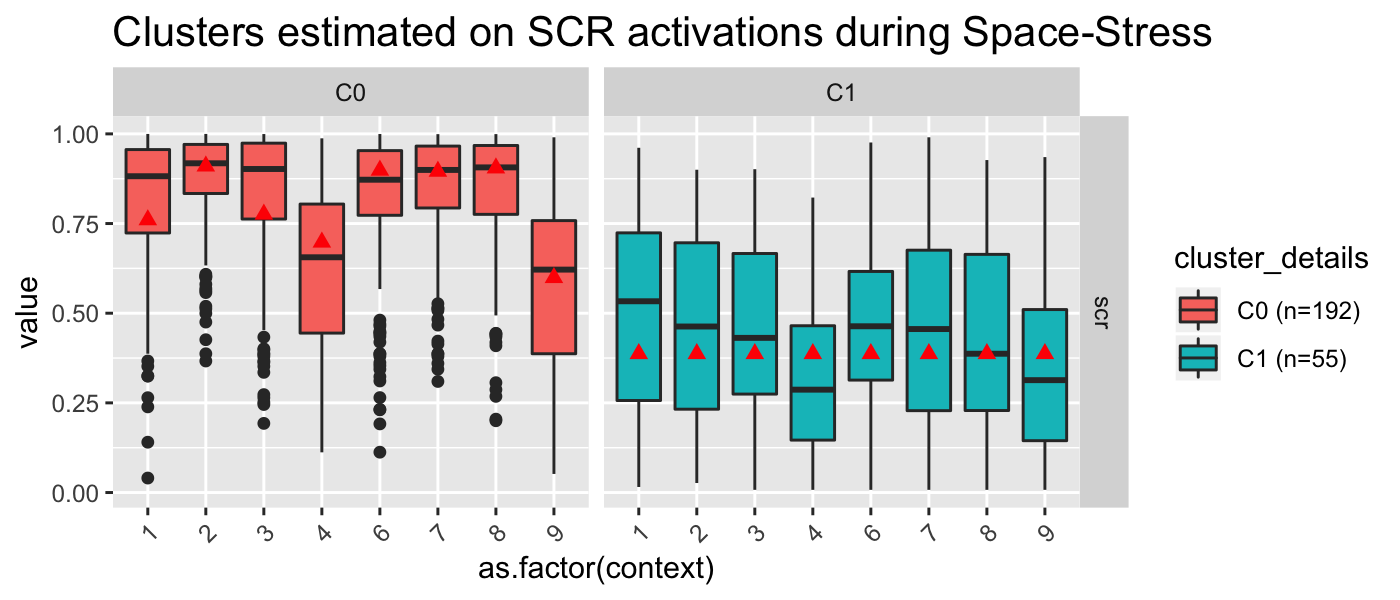

In [52]:
%%R -i df_complete -w 7 -h 3 --units in -r 200

tmp = reshape::melt(df_complete,
    id.vars=c('sequence', 'file_id', 'context', 'sequence_short', 'cluster', 'cluster_details', 'cluster_master'),
    measure.vars=c('scr'))

ggplot(tmp, aes(x=as.factor(context), y=value, fill=cluster_details)) +
    geom_boxplot() +
    geom_point(data=tmp[tmp$cluster_master,], 
               color=2, size=2, shape=17, show.legend=F) + 
facet_grid(variable~cluster, scales='free_y') +
labs(title="Clusters estimated on SCR activations during Space-Stress") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title=element_text(size=15))


In [53]:
case = profiling.sc
df_aff = case.df_aff
df_complete = case.df_complete[case.df_complete.sequence_short.isin(sequences_short)]

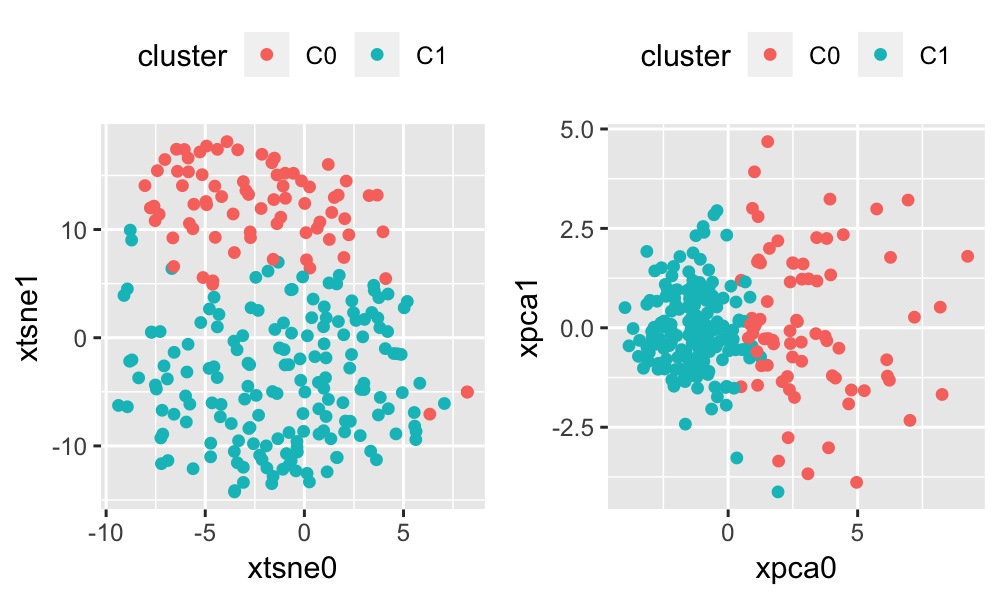

In [54]:
%%R -i df_aff  -w 5 -h 3 --units in -r 200

g1 = ggplot(df_aff, aes(x=xtsne0, y=xtsne1, color=cluster)) +
    geom_point() +
    theme(legend.position='top')
    
g2 = ggplot(df_aff, aes(x=xpca0, y=xpca1, color=cluster)) + 
    geom_point() +
    theme(legend.position='top')

cowplot::plot_grid(g1, g2, nrow=1)

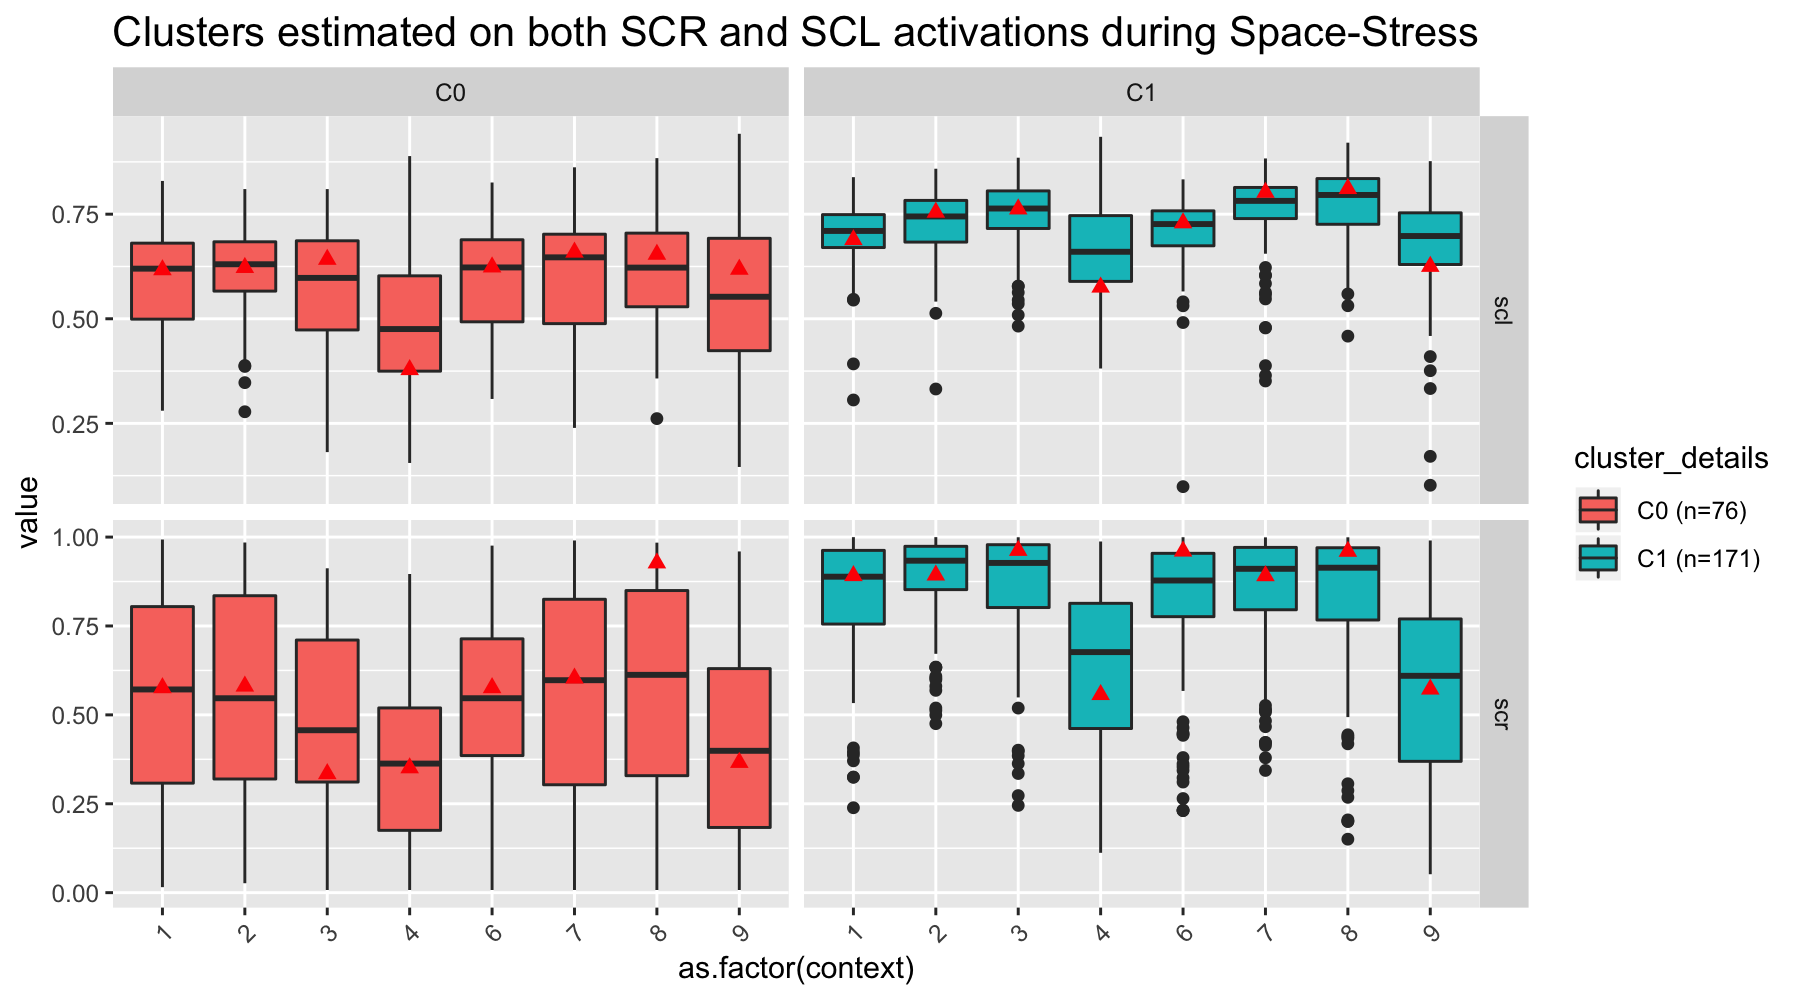

In [55]:
%%R -i df_complete -w 9 -h 5 --units in -r 200

tmp = reshape::melt(df_complete,
    id.vars=c('sequence', 'file_id', 'context', 'sequence_short', 'cluster', 'cluster_details', 'cluster_master'),
    measure.vars=c('scl', 'scr'))

ggplot(tmp, aes(x=as.factor(context), y=value, fill=cluster_details)) +
    geom_boxplot() +
    geom_point(data=tmp[tmp$cluster_master,], 
               color=2, size=2, shape=17, show.legend=F) + 
facet_grid(variable~cluster, scales='free_y') +
labs(title="Clusters estimated on both SCR and SCL activations during Space-Stress") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title=element_text(size=15))


In [56]:
case = profiling.cov
df_aff = case.df_aff
df_complete = case.df_complete[case.df_complete.sequence_short.isin(sequences_short)]

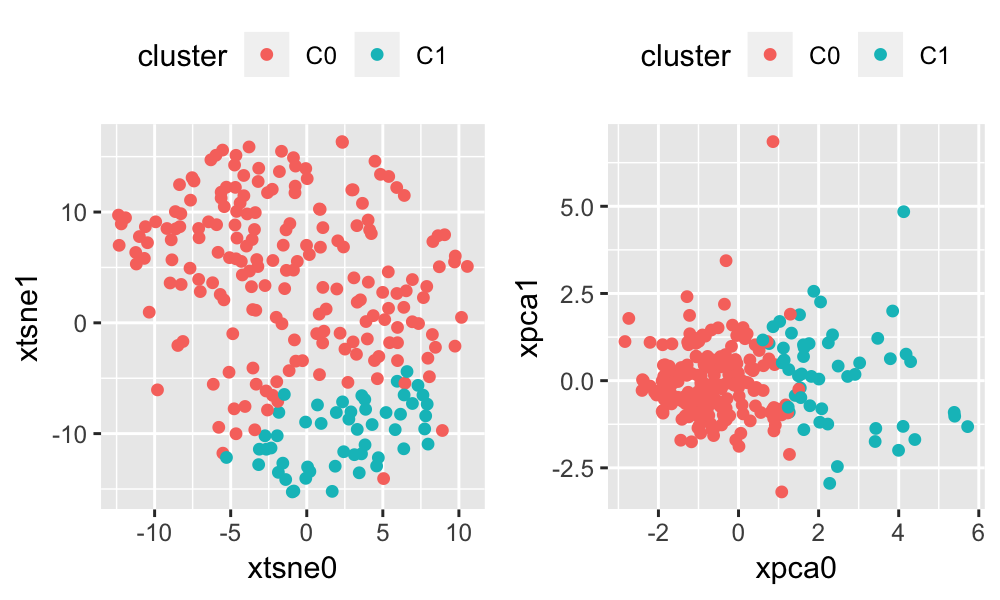

In [57]:
%%R -i df_aff  -w 5 -h 3 --units in -r 200

g1 = ggplot(df_aff, aes(x=xtsne0, y=xtsne1, color=cluster)) +
    geom_point() +
    theme(legend.position='top')
    
g2 = ggplot(df_aff, aes(x=xpca0, y=xpca1, color=cluster)) + 
    geom_point() +
    theme(legend.position='top') 
theme(plot.title=element_text(size=15))
cowplot::plot_grid(g1, g2, nrow=1) 

In [58]:
tmp = pd.concat([case.df_aff, case.df.reset_index()], axis=1)
tmp = pd.melt(tmp, id_vars=['file_id', 'cluster', 'cluster_details', 'cluster_master'], 
value_vars=['scr_scr', 'scr_scl', 'scr_difficulty', 'scl_scl', 'scl_difficulty',
      'difficulty_difficulty'], var_name='cov')

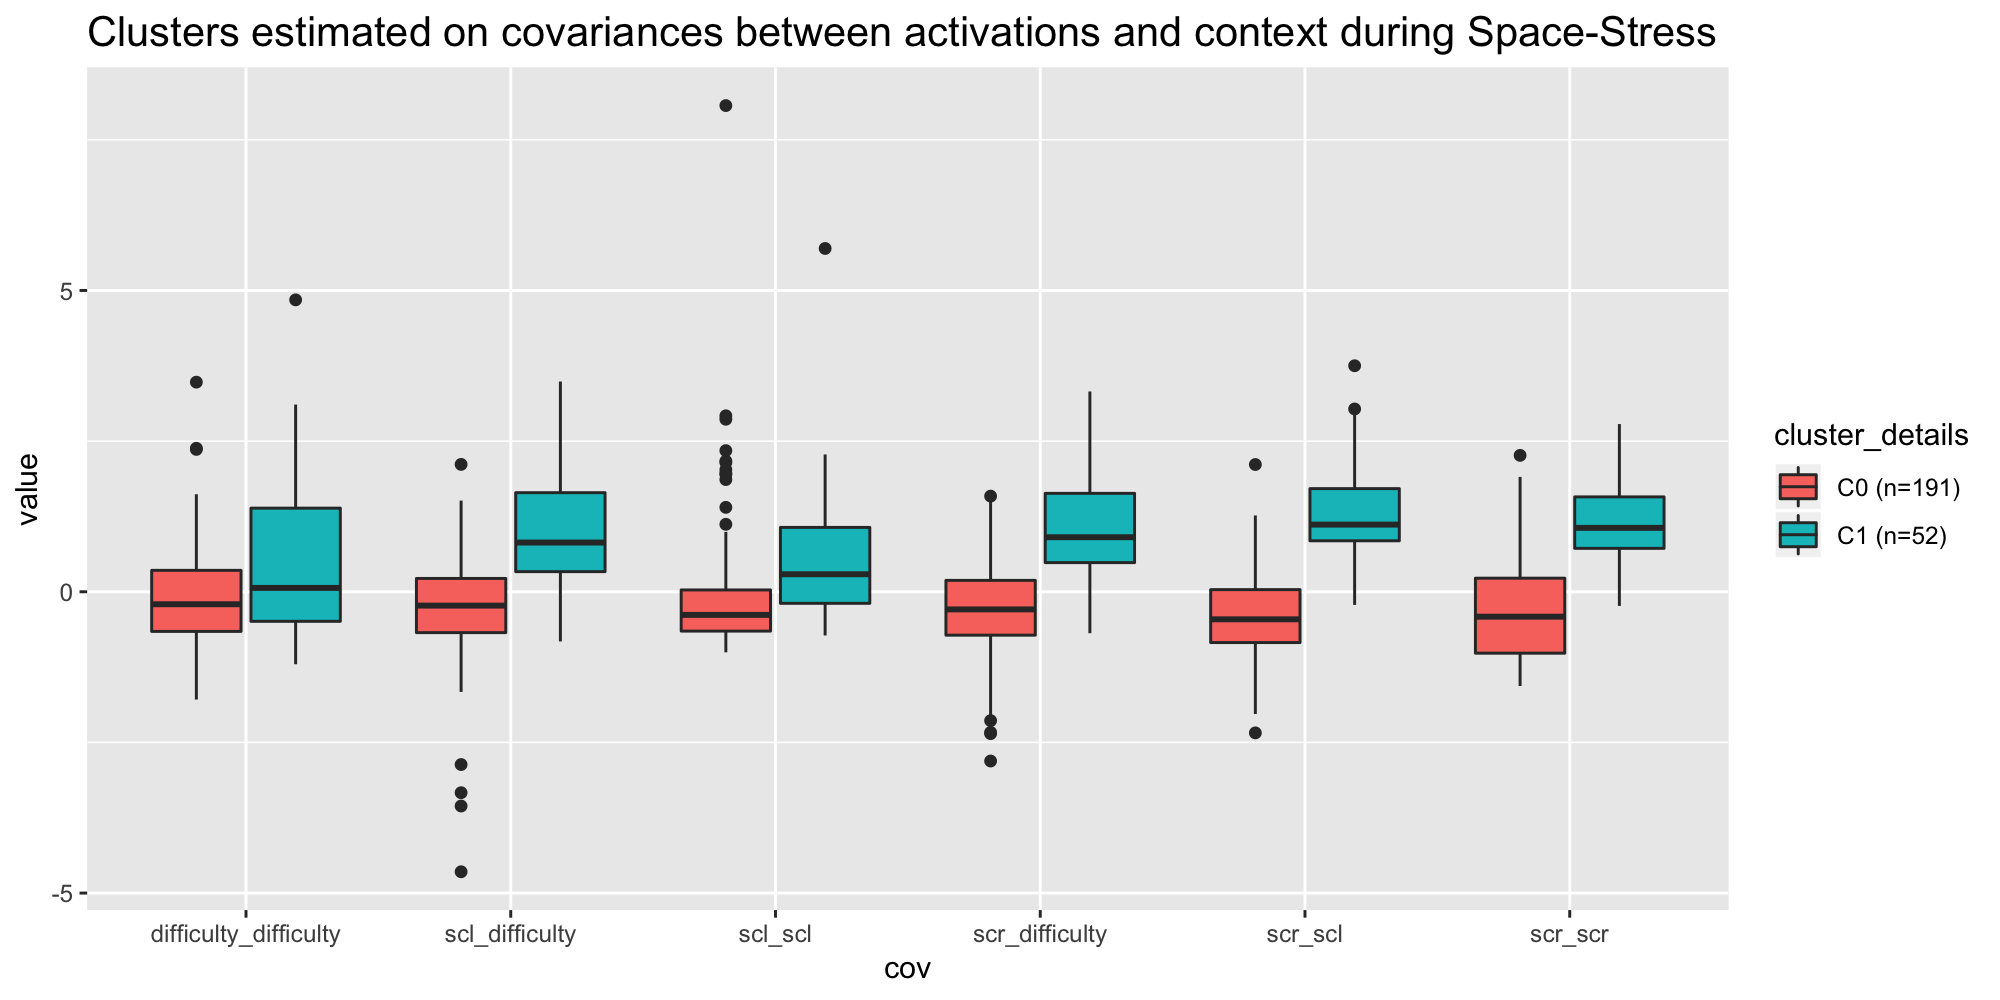

In [59]:
%%R -i tmp -w 10 -h 5 --units in -r 200
ggplot(tmp, aes(x=cov, y=value, fill=cluster_details)) +
    geom_boxplot()+
labs(title="Clusters estimated on covariances between activations and context during Space-Stress") + 
theme(plot.title=element_text(size=15))


## Conclusions

**On the activation model** <br>
I think the method is well appropriate to the DS request. <br>
The cross-validation seems robust and the distribution, at population level across modules is comforting that we did not overfit. <br>
<div class="alert alert-info">
Main result is that in 75% of the observations, phasic activation (resp decompression) goes togeteher with tonic activation (resp. decompression).
We could not identify, at population level, a clear relationship between activations degree during space-stress waves and the difficulty. 
</div>

That being said, I reflect upon:
- the choice of the training sequences, insofar as the survey during space-stress still show activations greater than 0.5. Which leads me to a second wondering: what is the *dynamic* of GSR? ie. Is it appropriate to train on sequences outside space-stress and test on space-stress or is their some *rebound effects*?
- the choice of the baseline-correction, insofar as we train on sequences that have been used to correct the features. 
- the features quality, insofar as we obtain 'prettier' clusters by selecting only scl_median and scr_rate than by considering all features. Are the other features just adding noise, or is it the scaling method that is not appropriate? 

**On the clustering** <br>
I am not convinced by the resulting clustering. The result is as follow: 
- for scr and scl  datasets, it seems that their is a 'compact mass' (~75% of the populations)  that shows the following activations: high during waves, low elsewhere. 
- for sc dataset, I don't see any difference between the two clusters. 
- for cov dataset, we draw two caricatural clusters: good adaptation between activation and difficulty, and no adaptation. 

The reason why I am not fully convinced is because the explained variance of PCA are quitee low, the affinity model cv scorig metric also, and that the number of cluster (N=2) is very few, when the 'affinity propagation' is rather used for greater amount of clusters. 

<div class="alert alert-info">
I am disapointed that the clustering accuracy and results are worse than the with the first approach (see gsr-exploration.ipynb by DOjeda), that only included SCL_median and SCR_rate as activation features. 
</div>


## Perspectives

- re-run the analysis using features that have not been baseline-corrected and choose an other baseline (eg. the whole session?) 
- choice of clustering: good thing with affinity propagation is that there is no fixed number of clusters and no assumption on their size. That beeing said, they seem to be more suitable for greater amount of clusters. When only 2 cluster can be identified, maybe we should reconsider the method? 
- scaling of the activation vector should be reviewed. 
- choice of the sequences to train the activation model should be reviewed. 

## Reproducibility

This final cell is useful to keep track of the exact environment and packages that you used

In [60]:
import sys
import os

print(sys.version)
is_conda = os.path.exists(os.path.join(sys.prefix, 'conda-meta'))
if is_conda:
    %conda list
else:
    %pip list

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
# packages in environment at /miniconda3/envs/gsr_sandbox-env:
#
# Name                    Version                   Build  Channel
_r-mutex                  1.0.0               anacondar_1  
appdirs                   1.4.3                    pypi_0    pypi
appnope                   0.1.0                    py37_0  
arrow                     0.14.2                   pypi_0    pypi
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
backoff                   1.8.0                    pypi_0    pypi
binaryornot               0.4.4                    pypi_0    pypi
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bwidget                   1.9.11                        1  
bzip2                     1.0.8                h1de35cc_0  
ca-certificates           2019.6.16          


Note: you may need to restart the kernel to use updated packages.
